#### **Libraries needed**

In [ ]:
!pip install grad-cam
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=f68a19d4957a35dc741eaf382d85e90b7ecfeafcc6a97ea7fe3b909c4eb110c2
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import models, transforms

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter, defaultdict
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall

import time
import copy
import seaborn as sns
import random
import cv2
import numpy as np

Some technicalites:


In [ ]:

%matplotlib inline

plt.ion()

In [ ]:
#Here we fix a seed so our executions are more reproducible

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Data processing**

We apply the same transformation to all the images

In [ ]:
weights = models.MobileNet_V2_Weights.DEFAULT
preprocess = weights.transforms()

We load now the images and divide it into training, validation, test and visualization groups.

In [9]:
train_percent = 0.8

gtsrb_path = "/content"

all_images_train = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=preprocess)

#We decided to use only a 1/4 of the original train and validation data

one_fourth = list(range(0, len(all_images_train), 4))

partial_dataset_train = torch.utils.data.Subset(all_images_train, one_fourth)

train_size = int(train_percent * len(partial_dataset_train))

val_size = int((len(partial_dataset_train) - train_size))

HTTPError: HTTP Error 403: Forbidden

We obtain the final sets of images and labels. We repeat the process with the visualization and test sets.

In [ ]:
train_set, val_set = random_split(partial_dataset_train,[train_size, val_size])

In [10]:
all_images_test = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=preprocess)

test_percent = 0.9

partial_dataset_test = torch.utils.data.Subset(all_images_test, one_fourth)

test_set_size = int(len(all_images_test)* test_percent)

test_vis_size= int(len(all_images_test) - test_set_size)

HTTPError: HTTP Error 403: Forbidden

In [ ]:
test_set, test_vis_set = random_split(all_images_test,[test_set_size,test_vis_size], )

In [ ]:
#Let's visualize the dataset we are using

train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Initialize a counter to keep track of class labels
class_counts = Counter()

# Iterate through the subset
for images, labels in train_loader:
    class_counts.update(labels.numpy())  # Update the counter with the labels of this batch

# Convert the counter to a sorted list
sorted_class_counts = sorted(class_counts.items())

# Unzip the sorted counts
classes, counts = zip(*sorted_class_counts)

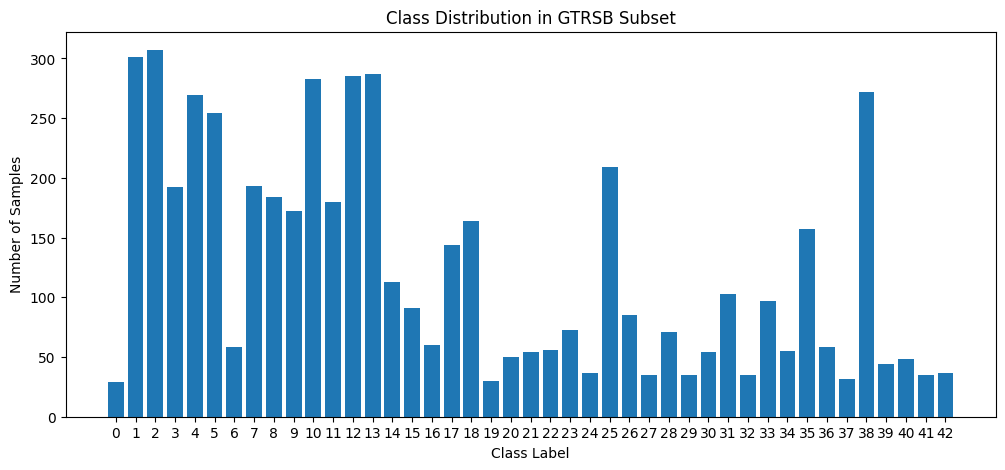

In [ ]:
# Plot the class distribution
plt.figure(figsize=(12, 5))
plt.bar(classes, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in GTRSB Subset')
plt.xticks(classes)  # Show class labels on x-axis
plt.show()

In [ ]:
training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

In [ ]:
#Here we associate each index of the labels with the corresponding class
class_names = [
    "Speed limit 20km/h",        # 0
    "Speed limit 30km/h",        # 1
    "Speed limit 50km/h",        # 2
    "Speed limit 60km/h",        # 3
    "Speed limit 70km/h",        # 4
    "Speed limit 80km/h",        # 5
    "End of speed limit 80km/h", # 6
    "Speed limit 100km/h",       # 7
    "Speed limit 120km/h",       # 8
    "No passing",                # 9
    "No passing for vehicles > 3.5t",  # 10
    "Right-of-way at intersection",    # 11
    "Priority road",             # 12
    "Yield",                     # 13
    "Stop",                      # 14
    "No vehicles",               # 15
    "Vehicles > 3.5t prohibited",      # 16
    "No entry",                  # 17
    "General caution",           # 18
    "Curve left",                # 19
    "Curve right",               # 20
    "Double curve",              # 21
    "Bumpy road",                # 22
    "Slippery road",             # 23
    "Road narrows right",        # 24
    "Road work",                 # 25
    "Traffic signals",           # 26
    "Pedestrians",               # 27
    "Children crossing",         # 28
    "Bicycles crossing",         # 29
    "Ice/snow warning",          # 30
    "Wild animals crossing",     # 31
    "End of speed & passing limits",  # 32
    "Turn right ahead",          # 33
    "Turn left ahead",           # 34
    "Ahead only",                # 35
    "Go straight or right",      # 36
    "Go straight or left",       # 37
    "Keep right",                # 38
    "Keep left",                 # 39
    "Roundabout",                # 40
    "End of no passing",         # 41
    "End of no passing > 3.5t"   # 42
]


In [ ]:
#Lets visualize the images we are working with
def imshow(images, labels):
  plt.figure(figsize=(15,15))
  for i in range(len(images)):
    plt.subplot(16,8,i+1)
    plt.imshow(images[i].permute(1,2,0)) # (3, 32, 32) -> (32, 32, 3)
    plt.title(labels[i].item())
    plt.axis("off")
  plt.show()

In [ ]:
test_vis_data_loader = DataLoader(test_vis_set, batch_size=64, shuffle=False)

#images, labels = next(iter(test_vis_data_loader)) # get a pack (64) of images
#imshow(images, labels)

### **Setting up our model**



In [ ]:
# Here we fix the hyperparameters that we will be using
bs = 128  # batch size
lr = 0.1  # learning rate
epochs = 15  # number of epochs
momentum = 0.9
step_size = 7
gamma = 0.1

Here we specify the structure of our model

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True)

in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_feature_number, 2048),  # First dense layer with 2048 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(2048, 1024),                # Second dense layer with 1024 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(1024, 512),                 # Third dense layer with 512 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(512, 256),                  # Fourth dense layer with 256 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(256, 43)                    # Final output layer with 43 classes (for GTSRB)
)

# We initialize the new added layers with the seed so we can reproduce the
# experiments.
for layer in model.classifier :
    if isinstance(layer, nn.Linear):  # Check if the layer is a Linear layer
        init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Xavier initialization
        if layer.bias is not None:
            init.zeros_(layer.bias)  # Initialize biases to zeros


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 157MB/s]


In [ ]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### **Some useful functions:**


Visualizing the loss and accuracy for validation and training


In [ ]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    plt.plot(train_acc)
    plt.title("Training accuracy")

    plt.subplot(2,2,2)
    plt.plot(val_acc)
    plt.title("Validation accuracy")

    plt.subplot(2,2,3)
    plt.plot(train_loss)
    plt.title("Training loss")

    plt.subplot(2,2,4)
    plt.plot(val_loss)
    plt.title("Validation loss")

    plt.show()

Setting up the visualizing method

In [ ]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
# Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot loss
    ax1.plot(train_loss, label='Training Loss', color='blue', marker='o')
    ax1.plot(val_loss, label='Validation Loss', color='orange', marker='o')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    # Plot accuracy
    ax2.plot(train_acc, label='Training Accuracy', color='green', marker='o')
    ax2.plot(val_acc, label='Validation Accuracy', color='red', marker='o')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

Method to make predictions over a set of images

In [ ]:
def evaluate_model(model, test_set, batch_size):
    was_training = model.training
    model.eval()

    model = model.to(device)

    all_preds = []
    all_labels = []

    test_data_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    return conf_matrix_normalized

Method to show some predictions on unseen images

In [ ]:
def show_predictions(model, vis_set, batch_size, num_of_images=6):
    was_training = model.training
    model.eval()
    model = model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    vis_data_loader = DataLoader(vis_set, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(vis_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1,2,0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Method to show gradients

In [ ]:
def plot_gradient_histogram(model):
    all_grads = []
    for param in model.classifier.parameters():
        if param.grad is not None:
            all_grads.append(param.grad.view(-1))
    if all_grads != []:
      all_grads = torch.cat(all_grads).cpu().numpy()

      plt.hist(all_grads, bins=100, range=(-1, 1))  # Adjust range if necessary
      plt.xlabel("Gradient Value")
      plt.ylabel("Frequency")
      plt.title("Gradient Histogram")
      plt.show()

#### **Training function**

Function for training our model

In [ ]:
def train_model(model, criterion, optimizer, lr_scheduler, train_set, val_set, num_epochs=25, batch_size=64):
    #We keep track of the time it takes to run this function
    since = time.time()

    #We utilise the GPU if its avaliable
    model = model.to(device)

    # We initialise the value we want to keep after execution
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Lists that contain the values after each epoch
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    #We encapsulate our images and labels in a Dataloader

    train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    data_loader = { "train" : train_data_loader, "val" : val_data_loader }
    data_loader_len = { "train" : len(train_data_loader), "val" : len(val_data_loader) }
    print("DataLoaders set up succesfully")
    #We repeat this proccess for the number of epochs fixed
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                lr_scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

            epoch_loss = running_loss / data_loader_len[phase]
            epoch_acc = running_corrects.double() / data_loader_len[phase]

            if phase == 'train':
                train_acc.append(float(epoch_acc))
                train_loss.append(float(epoch_loss))
            else:
                val_acc.append(float(epoch_acc))
                val_loss.append(float(epoch_loss))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            plot_gradient_histogram(model)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    visualize_metrics(train_acc, val_acc, train_loss, val_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

### **Transfer learning**

We prepare our model for transer learning.

In [ ]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion_loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizerSGD, step_size= step_size, gamma= gamma)

Let's aplicate transfer learning

DataLoaders set up succesfully
Epoch 1/15
--------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 196.1469 Acc: 71.5714


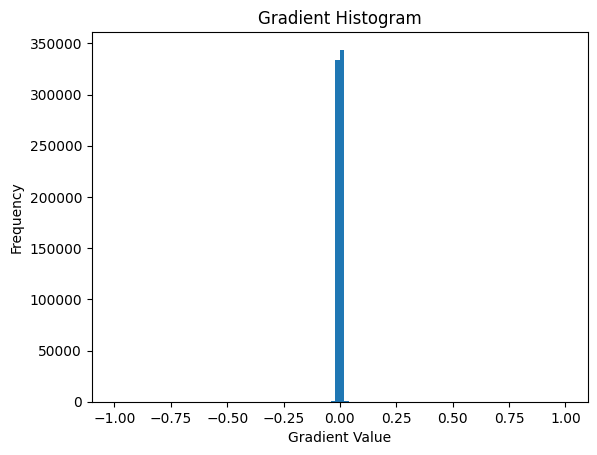

val Loss: 113.2265 Acc: 85.8182
Epoch 2/15
--------------------
train Loss: 54.8486 Acc: 109.4762


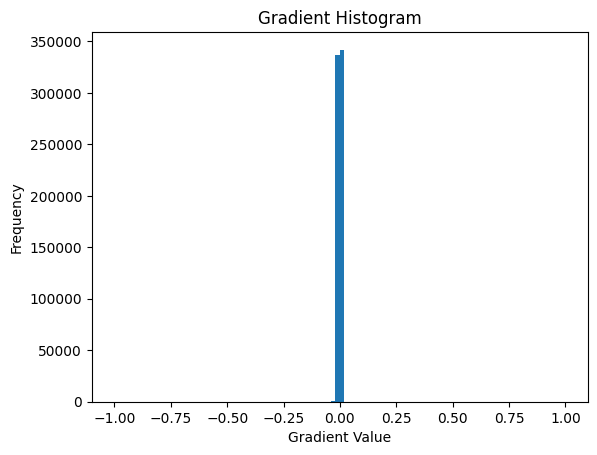

val Loss: 75.8700 Acc: 97.2727
Epoch 3/15
--------------------
train Loss: 23.1067 Acc: 120.8571


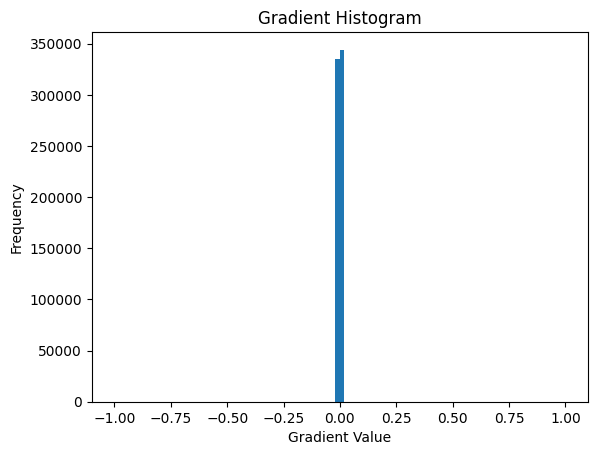

val Loss: 64.8053 Acc: 99.9091
Epoch 4/15
--------------------
train Loss: 10.2323 Acc: 124.9048


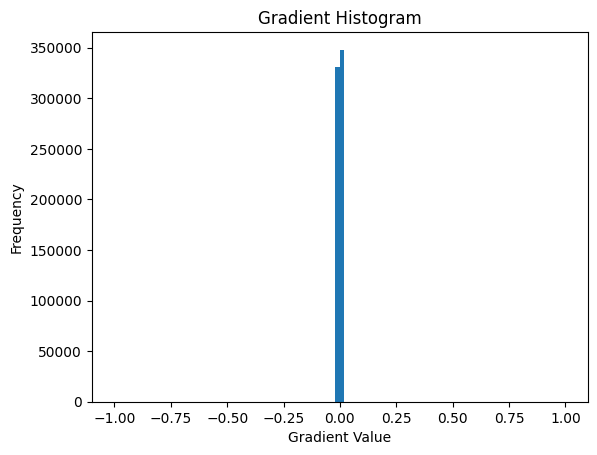

val Loss: 59.4440 Acc: 102.8182
Epoch 5/15
--------------------
train Loss: 5.4418 Acc: 126.0238


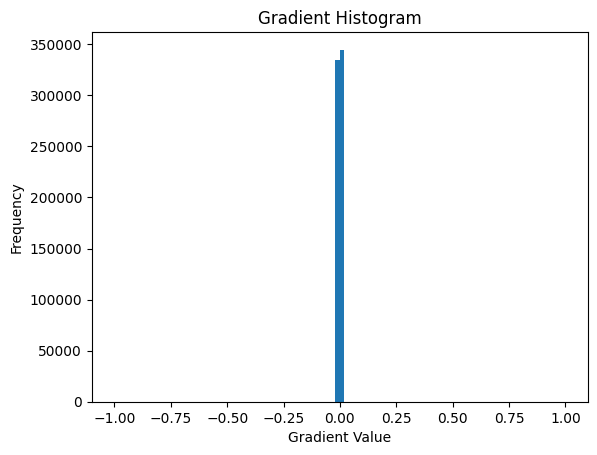

val Loss: 58.6844 Acc: 103.0000
Epoch 6/15
--------------------
train Loss: 3.4310 Acc: 126.6190


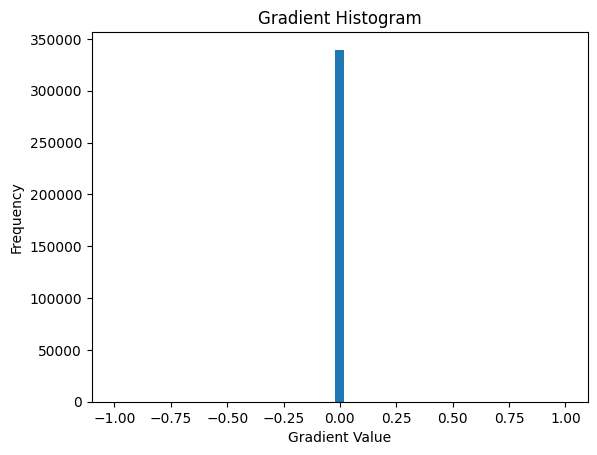

val Loss: 55.1754 Acc: 103.9091
Epoch 7/15
--------------------
train Loss: 2.2024 Acc: 126.7619


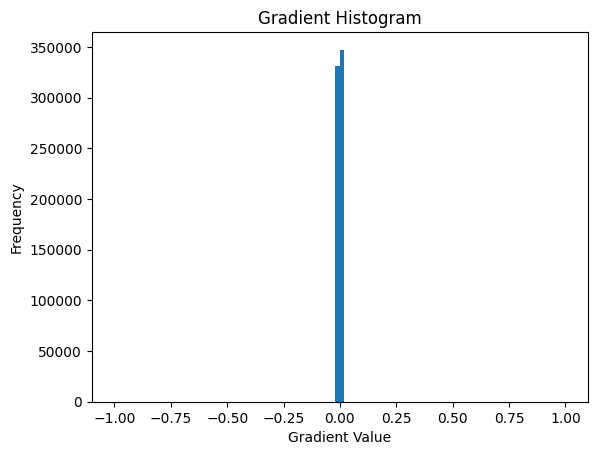

val Loss: 54.9617 Acc: 104.5455
Epoch 8/15
--------------------
train Loss: 1.9412 Acc: 126.8333


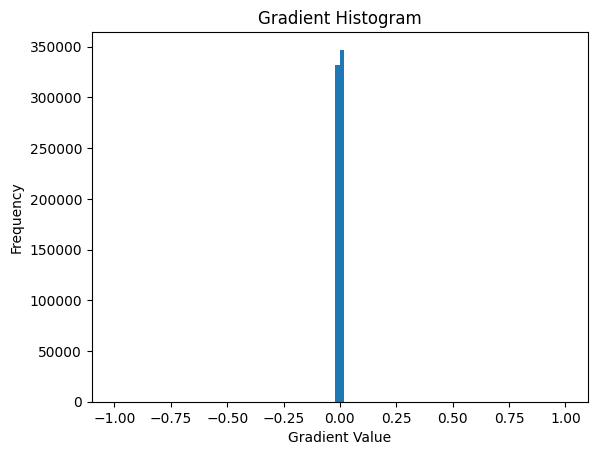

val Loss: 54.1297 Acc: 105.1818
Epoch 9/15
--------------------
train Loss: 1.8567 Acc: 126.8333


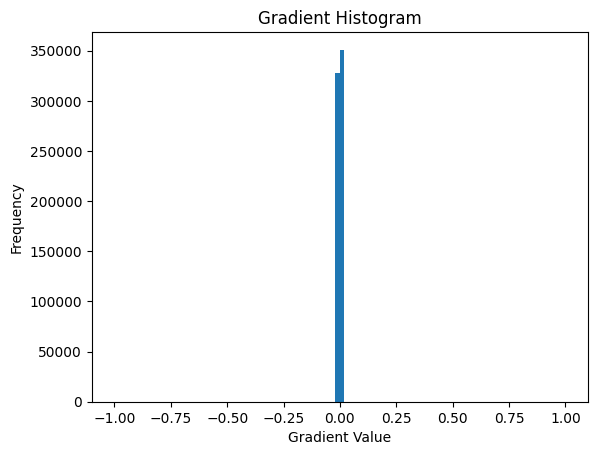

val Loss: 53.6941 Acc: 105.0909
Epoch 10/15
--------------------
train Loss: 1.9358 Acc: 126.7381


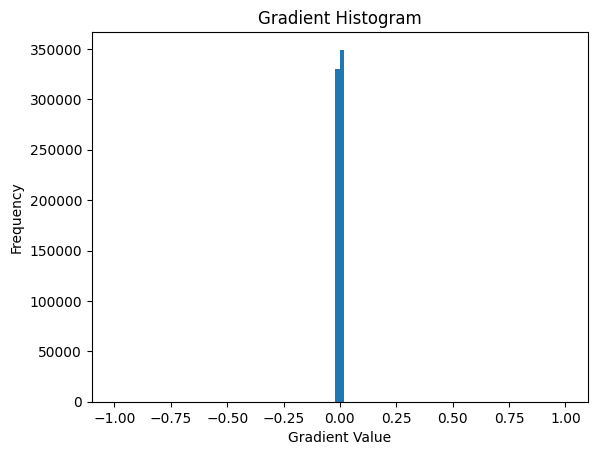

val Loss: 54.2545 Acc: 104.7273
Epoch 11/15
--------------------
train Loss: 1.6160 Acc: 126.8571


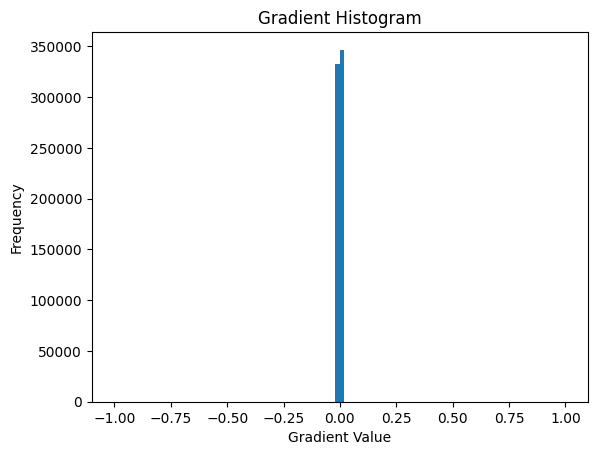

val Loss: 54.1931 Acc: 105.0909
Epoch 12/15
--------------------
train Loss: 1.8255 Acc: 126.8095


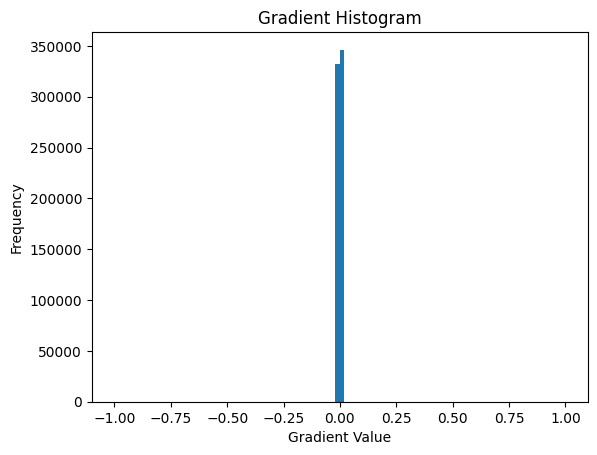

val Loss: 53.8631 Acc: 104.7273
Epoch 13/15
--------------------
train Loss: 1.6042 Acc: 126.8571


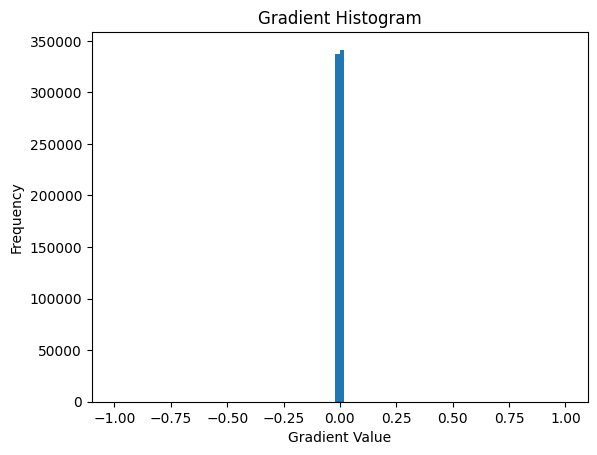

val Loss: 54.5772 Acc: 104.7273
Epoch 14/15
--------------------
train Loss: 1.5799 Acc: 126.8095


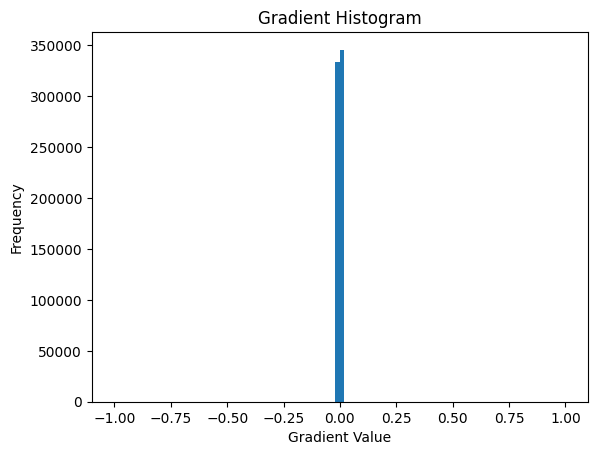

val Loss: 54.1423 Acc: 104.7273
Epoch 15/15
--------------------
train Loss: 1.5437 Acc: 126.8333


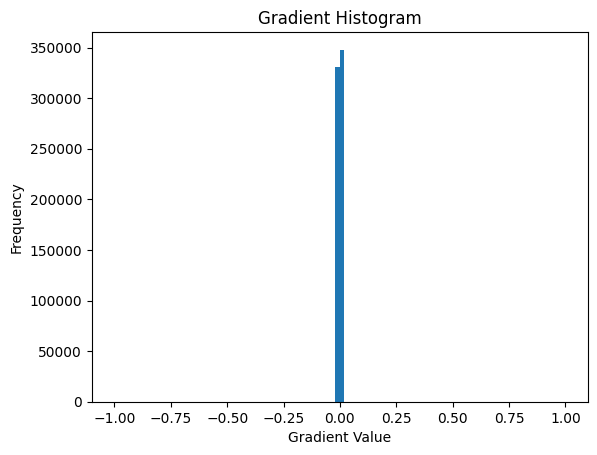

val Loss: 54.2504 Acc: 105.0909
Training complete in 7m 27s
Best val Acc: 105.181818


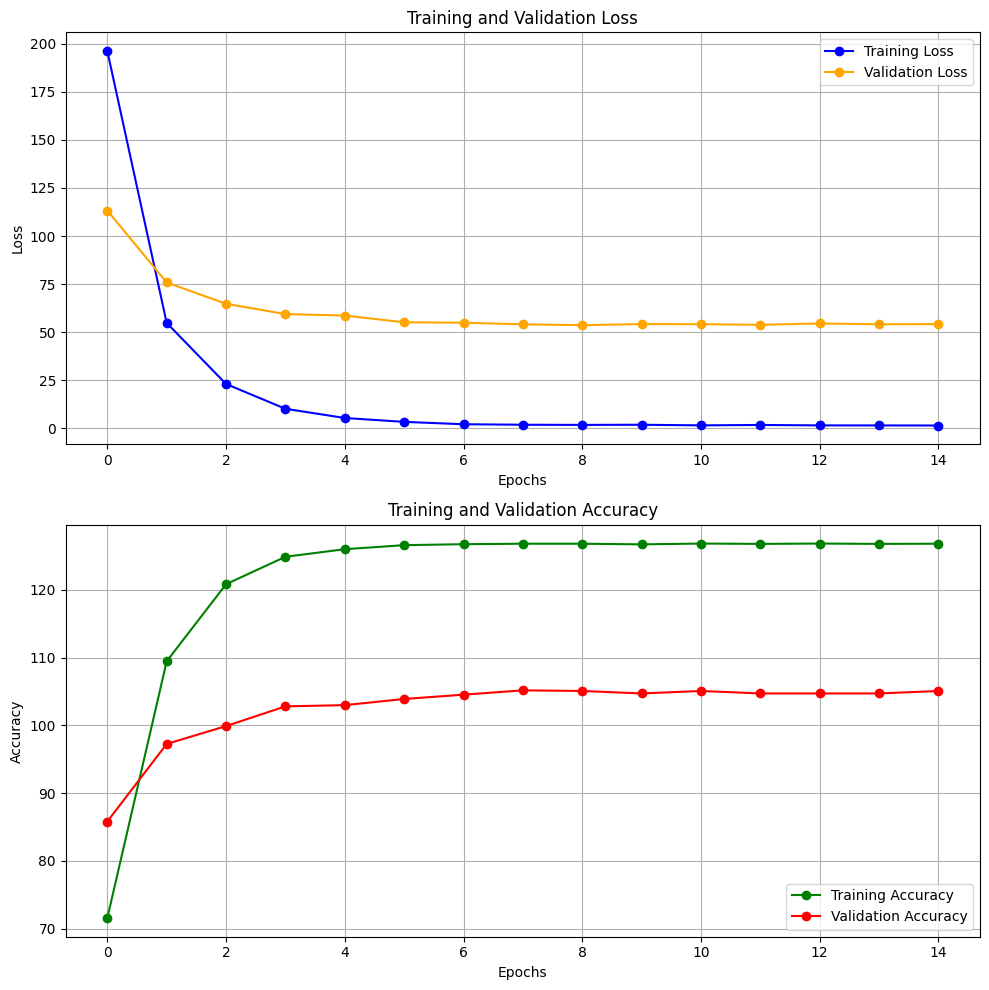

In [ ]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=epochs, batch_size=bs)

Let's visuzalize the results with a confusion matrix over the test set.

ValueError: Unknown format code 'd' for object of type 'float'

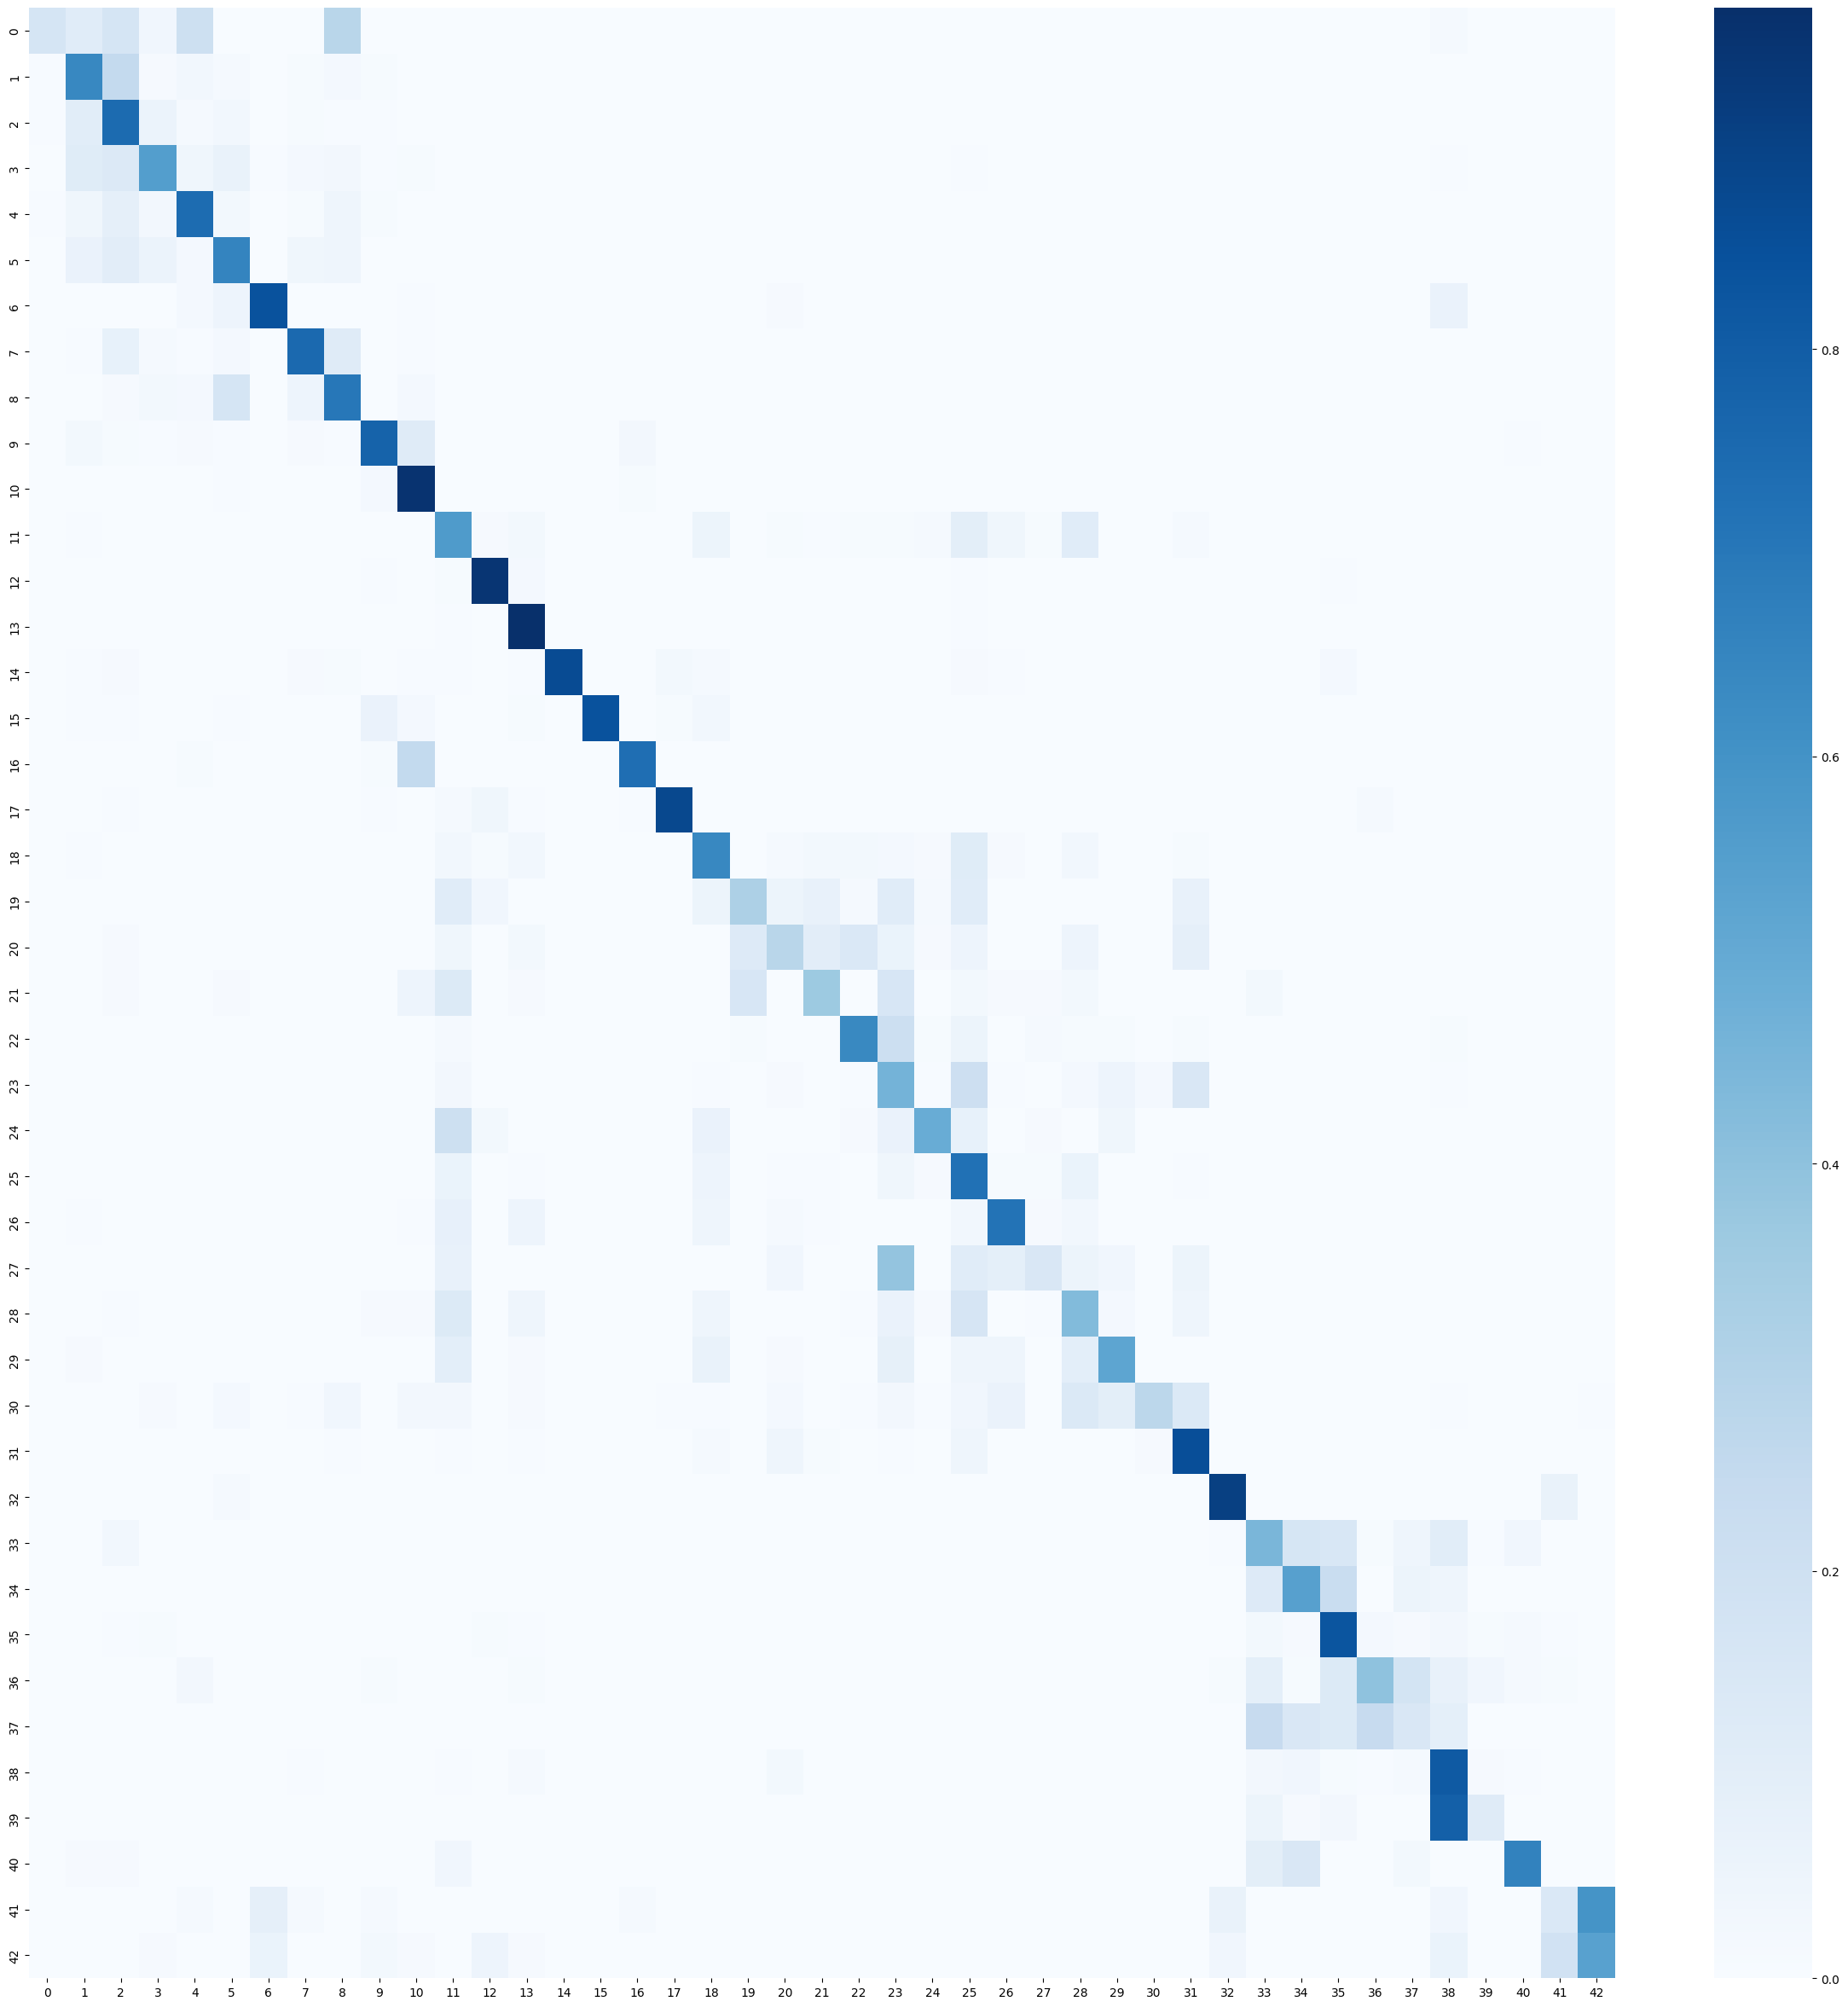

In [ ]:
conf_matrix = evaluate_model(model, test_set, bs)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Let's see a batch of the predictions and their true labels

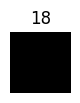

In [ ]:
test_dataloader = DataLoader(test_vis_set)

imgs, labels = next(iter(test_dataloader))

imshow(imgs, labels)

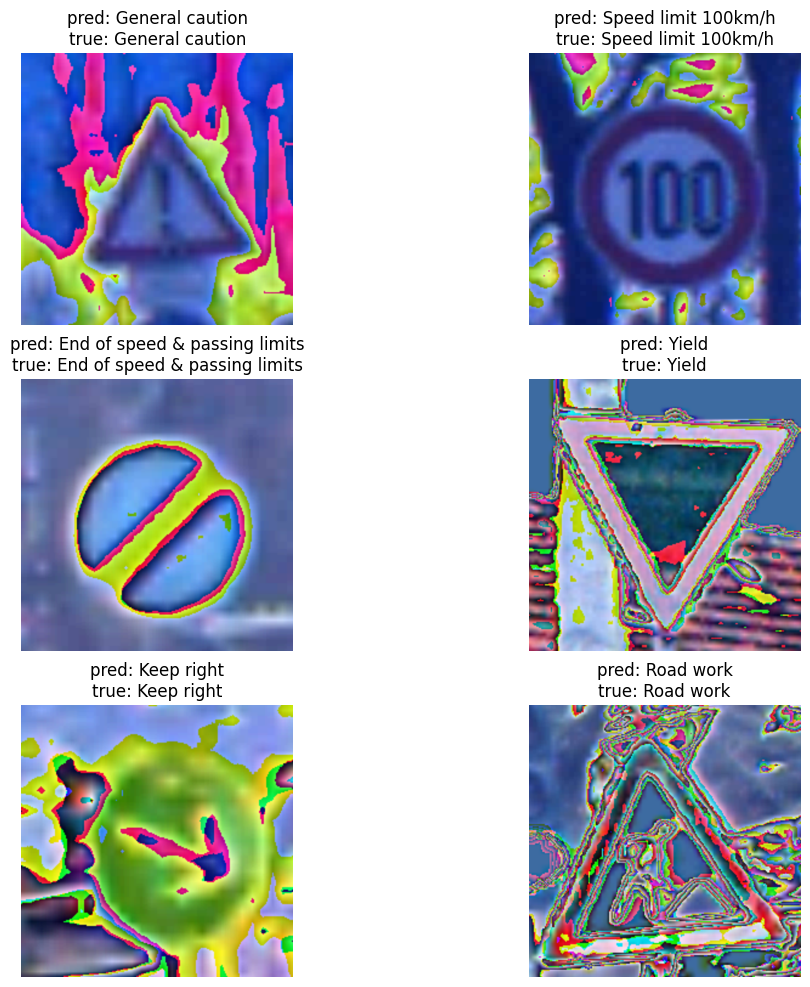

In [ ]:
show_predictions(model, test_vis_set, bs) # 6 images are shown by default

### **Fine tuning**

We unfreeze the decoder

In [ ]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Now we retrain the model for a few epochs

DataLoaders set up succesfully
Epoch 1/8
--------------------
train Loss: 290.2608 Acc: 5.0476


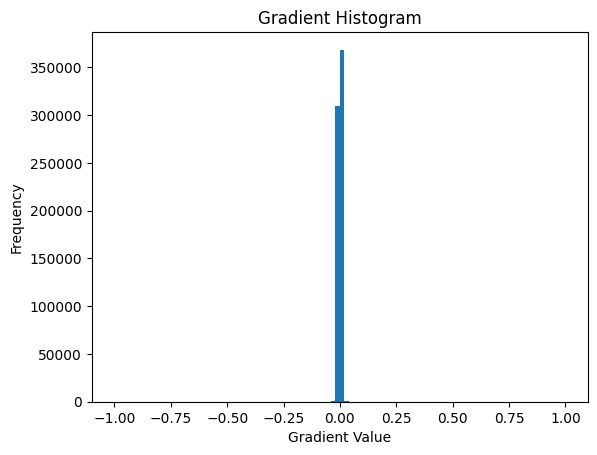

val Loss: 1290.3018 Acc: 1.8571
Epoch 2/8
--------------------
train Loss: 228.7256 Acc: 4.9881


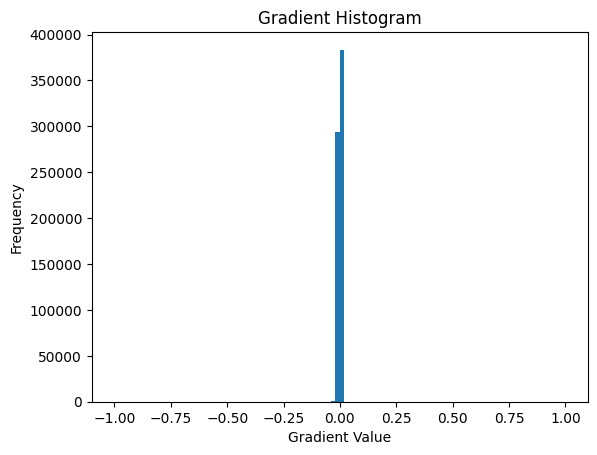

val Loss: 271.1560 Acc: 4.6667
Epoch 3/8
--------------------
train Loss: 220.6868 Acc: 5.2381


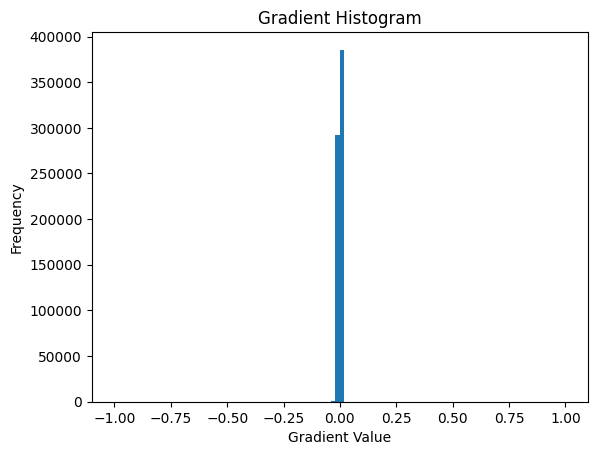

val Loss: 225.0364 Acc: 4.7619
Epoch 4/8
--------------------
train Loss: 214.1221 Acc: 6.2857


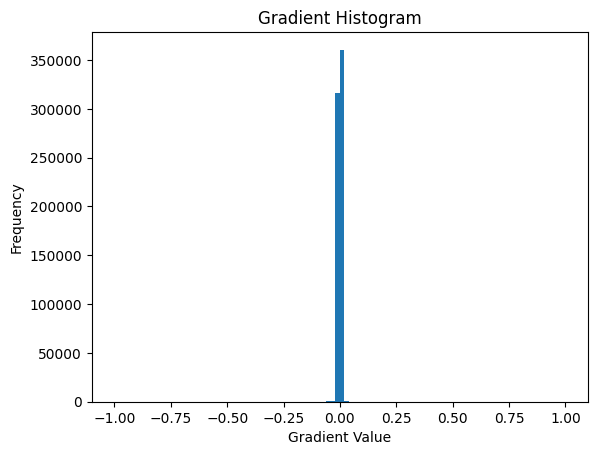

val Loss: 215.5599 Acc: 6.0952
Epoch 5/8
--------------------
train Loss: 208.2924 Acc: 7.1667


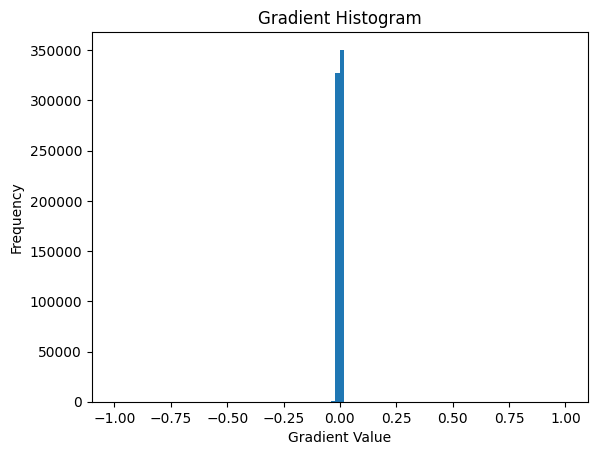

val Loss: 211.2389 Acc: 6.9048
Epoch 6/8
--------------------
train Loss: 196.9683 Acc: 9.0119


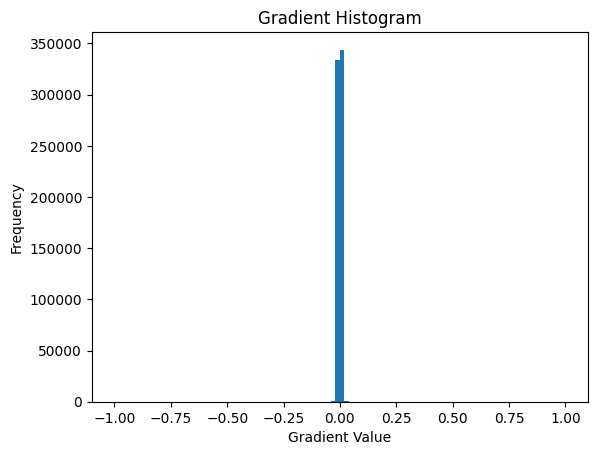

val Loss: 196.2891 Acc: 9.5238
Epoch 7/8
--------------------
train Loss: 179.3218 Acc: 12.1667


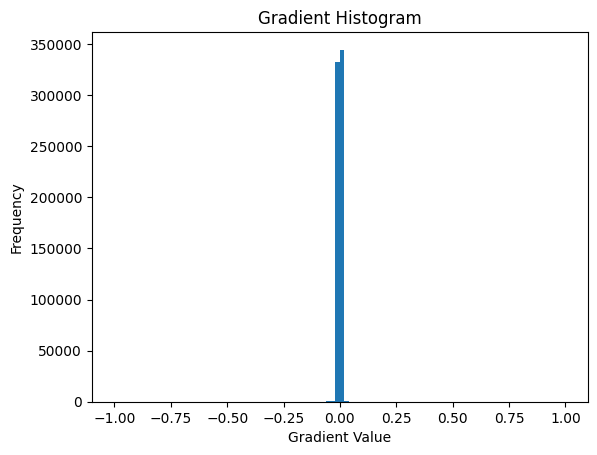

val Loss: 179.8841 Acc: 11.8571
Epoch 8/8
--------------------
train Loss: 161.3650 Acc: 16.0714


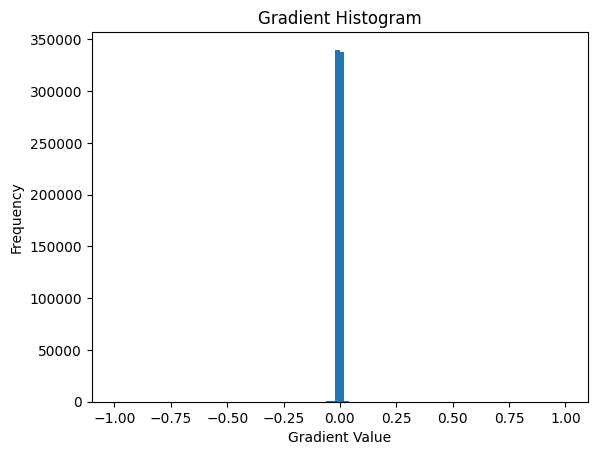

val Loss: 158.6720 Acc: 16.9524
Training complete in 5m 9s
Best val Acc: 16.952381


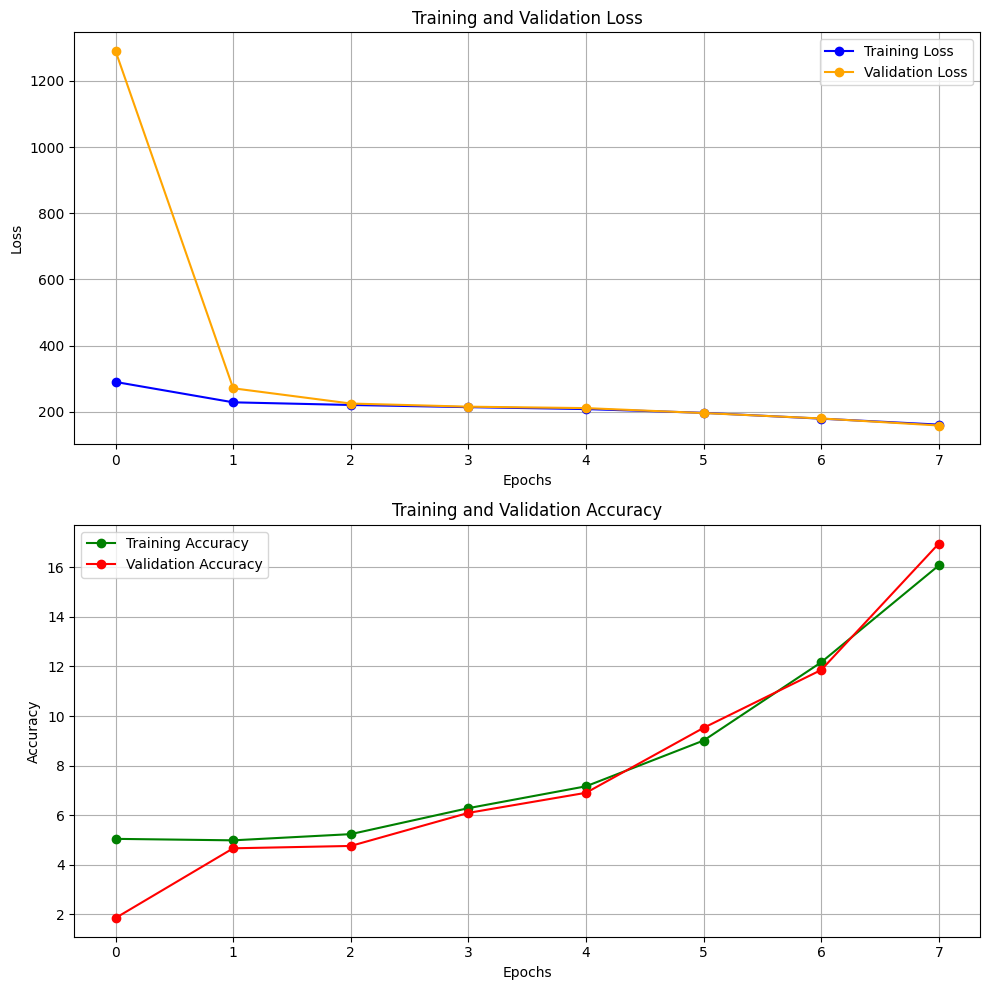

In [ ]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=8)

And finally we visualize the results:


In [ ]:
conf_matrix = evaluate_model(model, test_vis_set, bs)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'np' is not defined

### **Experimenting with increasing the learning rate**

The motivation for experimenting with the learning rate comes from the fact that, because our gradients were vanishing, we decided to add a Batch Normalization layer. Therefore now we can try to initialize our model with higher learning rates. We also want to achieve a better accuracy, therefore we
will try to use CLR and a deeper study of the reasonable boundaries that
are suitable for our model and dataset.

In [ ]:
#First of all let's get our model back to the early stage

def reset_parameters(model) :
  model = torchvision.models.mobilenet_v2(pretrained=True)

  in_feature_number = model.classifier[1].in_features

  model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
      nn.Linear(in_feature_number, 512),
      nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
      nn.ReLU(),
      nn.Linear(512, 43)
  )

  # We initialize the new added layers with the seed so we can reproduce the
  # experiments.
  for layer in model.classifier :
      if isinstance(layer, nn.Linear):  # Check if the layer is a Linear layer
          init.xavier_uniform_(layer.weight, gain=init.calculate_gain('relu'))  # Xavier initialization
          if layer.bias is not None:
              init.zeros_(layer.bias)  # Initialize biases to zeros

  return model


Let's also modify our train function so we can play with the learning rates more easily and efficientrly

In [ ]:
def train_model(model,
                criterion,
                optimizer,
                lr_scheduler,
                train_set,
                val_set,
                num_epochs=25,
                batch_size=64,
                batches_per_epoch=None,
                show = False
                ):
    #We keep track of the time it takes to run this function
    since = time.time()

    #We utilise the GPU if its avaliable
    model = model.to(device)

    # We initialise the value we want to keep after execution
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Lists that contain the values after each epoch
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    train_acc_hist = []
    val_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []

    plot_time_train = []
    plot_time_valid = []

    #We encapsulate our images and labels in a Dataloader

    # Set up data loaders
    if batches_per_epoch == None:
      # Use all images
      train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=bs,
                                            shuffle=True, num_workers=2)
      val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=bs,
                                          shuffle=False, num_workers=2)
      batches_per_epoch = len(train_data_loader)
    else:
      # Only use a subset of the data
      subset_indices = list(range(batches_per_epoch*bs))
      train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices, ), num_workers=2)

      # Use one fourth for validation
      subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
      val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)


    data_loader = { "train" : train_data_loader, "val" : val_data_loader }
    data_loader_len = { "train" : len(train_data_loader), "val" : len(val_data_loader) }
    print("DataLoaders set up succesfully")

    # Total number of batches
    t=1
    T = batches_per_epoch * epochs

    #We repeat this proccess for the number of epochs fixed
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} Batches per epoch: {batches_per_epoch} Total number of batches: {T}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                t = 1
            else:
                model.eval()   # Set model to evaluate mode
                t = 1

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                optimizer.param_groups[0]['lr'] = lr_scheduler(t,T,lr=optimizer.param_groups[0]['lr'])

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

                if phase == 'train':
                  train_acc_hist.append(float(curr_corrects))
                  train_loss_hist.append(float(curr_loss))
                  print('t',t,'lr',optimizer.param_groups[0]['lr'],'train loss',curr_loss)
                  plot_time_train.append(t)
                  t += 1
                else:
                  val_acc_hist.append(float(curr_corrects))
                  val_loss_hist.append(float(curr_loss))
                  plot_time_valid.append(t)
                  t += 1

            epoch_loss = running_loss / data_loader_len[phase]
            epoch_acc = running_corrects.double() / data_loader_len[phase]

            if phase == 'train':
                train_acc.append(float(curr_corrects))
                train_loss.append(float(curr_loss))
            else:
                val_acc.append(float(curr_corrects))
                val_loss.append(float(curr_loss))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if show == True :
              plot_gradient_histogram(model)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
    #    time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))
#
    #visualize_metrics(train_acc, val_acc, train_loss, val_loss)
#
    ## load best model weights
    model.load_state_dict(best_model_wts)

    if show == True :
      plt.figure()
      lines = []
      labels = []
      l, = plt.plot(plot_time_train,train_loss_history)
      lines.append(l)
      labels.append('Training')
      plt.title('Loss')
      plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
      plt.show()
    #We return the train_loss
    return train_loss_hist

In [ ]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

[1.00000000e-06 1.32571137e-06 1.75751062e-06 2.32995181e-06
 3.08884360e-06 4.09491506e-06 5.42867544e-06 7.19685673e-06
 9.54095476e-06 1.26485522e-05 1.67683294e-05 2.22299648e-05
 2.94705170e-05 3.90693994e-05 5.17947468e-05 6.86648845e-05
 9.10298178e-05 1.20679264e-04 1.59985872e-04 2.12095089e-04
 2.81176870e-04 3.72759372e-04 4.94171336e-04 6.55128557e-04
 8.68511374e-04 1.15139540e-03 1.52641797e-03 2.02358965e-03
 2.68269580e-03 3.55648031e-03 4.71486636e-03 6.25055193e-03
 8.28642773e-03 1.09854114e-02 1.45634848e-02 1.93069773e-02
 2.55954792e-02 3.39322177e-02 4.49843267e-02 5.96362332e-02
 7.90604321e-02 1.04811313e-01 1.38949549e-01 1.84206997e-01
 2.44205309e-01 3.23745754e-01 4.29193426e-01 5.68986603e-01
 7.54312006e-01 1.00000000e+00]
DataLoaders set up succesfully
Epoch 1/1 Batches per epoch: 50 Total number of batches: 50
--------------------
t 1 lr 1e-06 train loss 290.9109191894531
t 2 lr 1.325711365590108e-06 train loss 298.74835205078125
t 3 lr 1.75751062485479

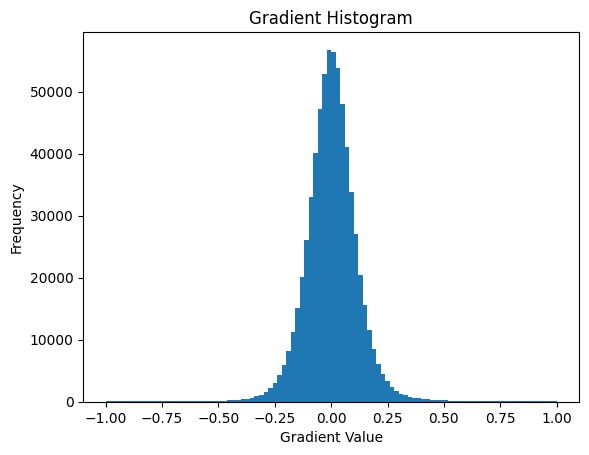

val Loss: 293.1146 Acc: 1.7692


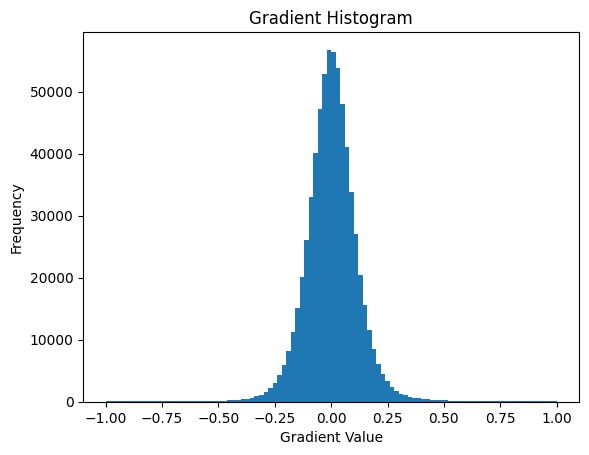

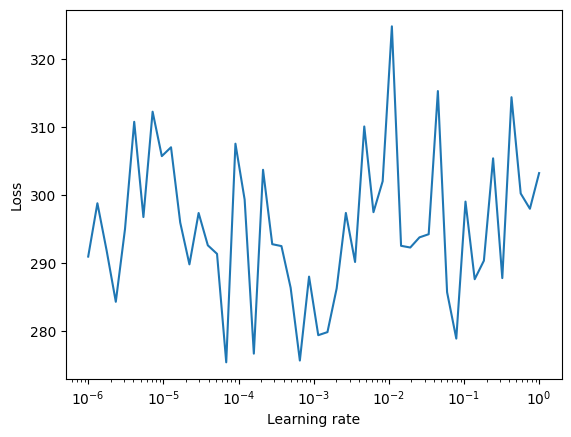

In [ ]:
#Let's experiment with different learning rates and see which ones are more
# interesting for our model.

epochs = 1
batches_per_epoch = 50
lr_list = np.logspace(-6,0,batches_per_epoch) # Your code goes here
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

print(lr_list)

# Run
model = reset_parameters(model)

train_loss_history = train_model(model, criterion_loss, optimizerSGD, lr_finder, train_set, val_set, num_epochs=epochs,batches_per_epoch=batches_per_epoch)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis
plt.xlabel('Learning rate');
plt.ylabel('Loss');

Seeing the above graph makes us think that the best learning rates will be from 10^{-3/2} to 10^{-1}. Therefore we apply CLR with those values.

In [ ]:
lr_list = np.logspace(-3,-1,50) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
print(lr_list)
batches_per_epoch = len(lr_list)
epochs = 1
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


def CLR(t,T,lr):
  return lr_list[t-1]

model = reset_parameters(model)
for cycle in range(5):
  train_loss_history = train_model(model, criterion_loss, optimizerSGD, CLR, train_set, val_set, num_epochs=epochs,batches_per_epoch=batches_per_epoch, show=True)


[0.1        0.09102982 0.08286428 0.0754312  0.06866488 0.06250552
 0.05689866 0.05179475 0.04714866 0.04291934 0.0390694  0.0355648
 0.03237458 0.02947052 0.02682696 0.02442053 0.02222996 0.0202359
 0.0184207  0.01676833 0.01526418 0.01389495 0.01264855 0.01151395
 0.01048113 0.00954095 0.00868511 0.00790604 0.00719686 0.00655129
 0.00596362 0.00542868 0.00494171 0.00449843 0.00409492 0.00372759
 0.00339322 0.00308884 0.00281177 0.00255955 0.00232995 0.00212095
 0.0019307  0.00175751 0.00159986 0.00145635 0.00132571 0.00120679
 0.00109854 0.001     ]
DataLoaders set up succesfully
Epoch 1/1 Batches per epoch: 50 Total number of batches: 50
--------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


t 1 lr 0.1 train loss 272.90325927734375


#### **Implementing the new architecture**

In [ ]:
# Load the pre-trained MobileNetV2 model
# pretrained=True indicates we'll use weights pre-trained on ImageNet
model = torchvision.models.mobilenet_v2(pretrained=True)

# Get the number of input features for the classifier's fully connected layer
# This is needed to define the input size for our custom classifier
in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_feature_number, 2048),  # First dense layer with 2048 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(2048, 1024),                # Second dense layer with 1024 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(1024, 512),                 # Third dense layer with 512 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(512, 256),                  # Fourth dense layer with 256 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(256, 43)                    # Final output layer with 43 classes (for GTSRB)
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion_loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizerSGD, step_size= step_size, gamma= gamma)

DataLoaders set up succesfully
Epoch 1/10
--------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 432.7354 Acc: 10.6667


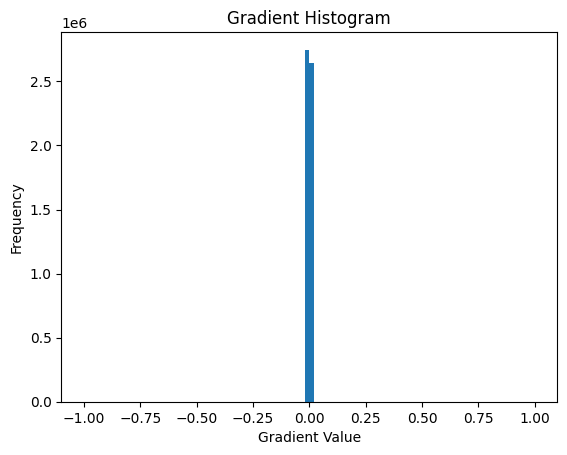

val Loss: 372.6912 Acc: 17.3636
Epoch 2/10
--------------------
train Loss: 316.3548 Acc: 29.1667


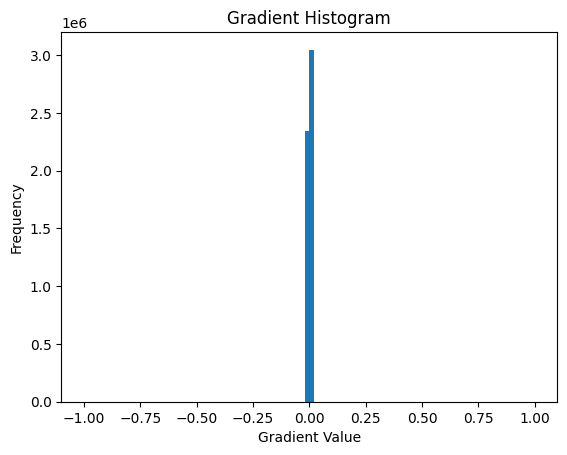

val Loss: 263.6881 Acc: 37.9091
Epoch 3/10
--------------------
train Loss: 257.9752 Acc: 41.2143


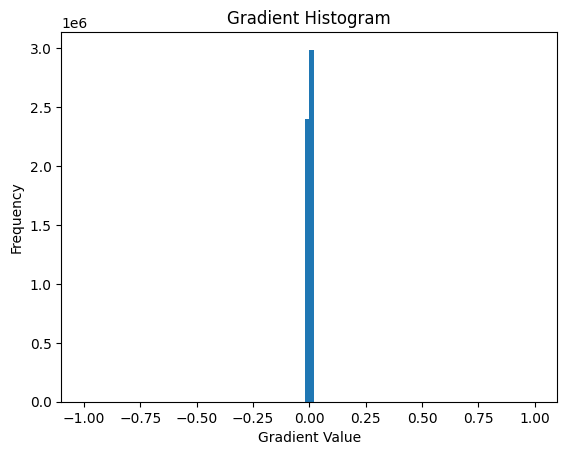

val Loss: 234.8935 Acc: 44.6364
Epoch 4/10
--------------------
train Loss: 214.9811 Acc: 54.0476


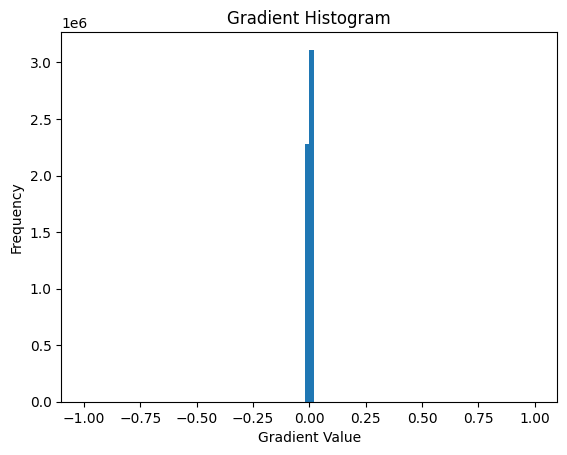

val Loss: 195.9287 Acc: 50.5455
Epoch 5/10
--------------------
train Loss: 199.7549 Acc: 59.0714


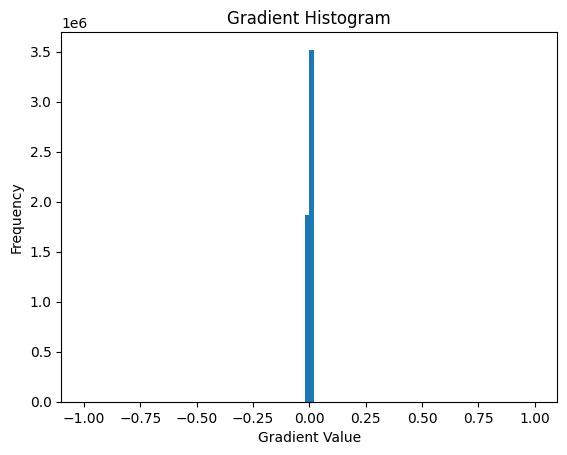

val Loss: 191.3043 Acc: 58.5455
Epoch 6/10
--------------------
train Loss: 175.7367 Acc: 65.9048


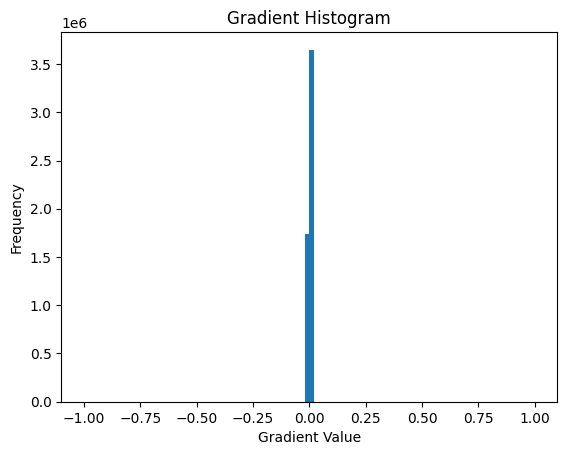

val Loss: 179.8767 Acc: 60.8182
Epoch 7/10
--------------------
train Loss: 141.2597 Acc: 78.0000


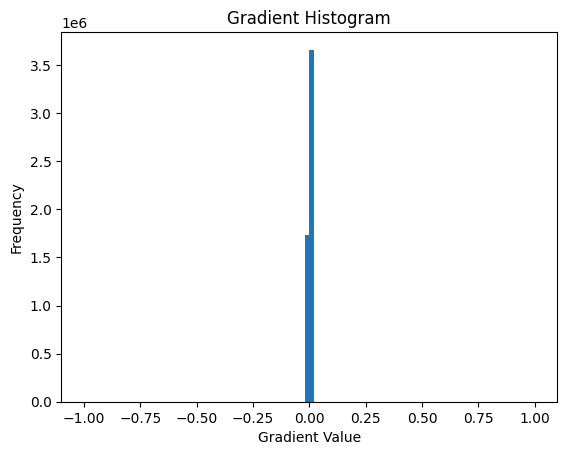

val Loss: 144.8772 Acc: 73.3636
Epoch 8/10
--------------------
train Loss: 120.6073 Acc: 84.2143


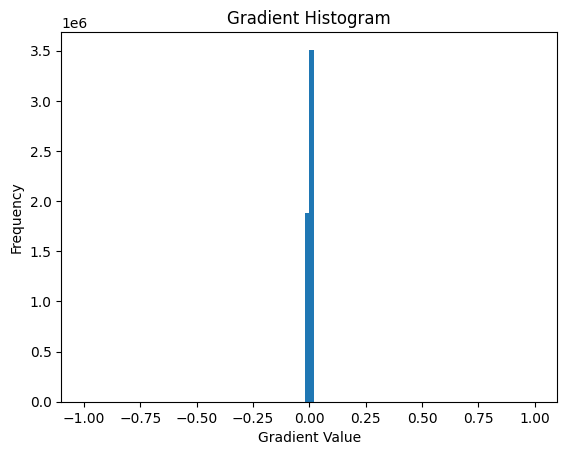

val Loss: 139.8094 Acc: 75.5455
Epoch 9/10
--------------------
train Loss: 111.9677 Acc: 87.4286


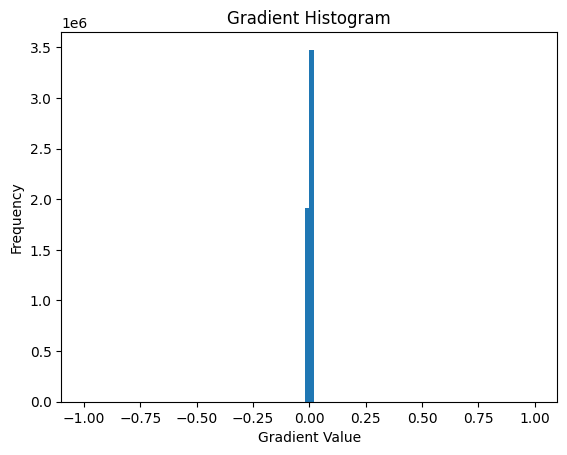

val Loss: 135.6805 Acc: 75.6364
Epoch 10/10
--------------------
train Loss: 103.5653 Acc: 90.0952


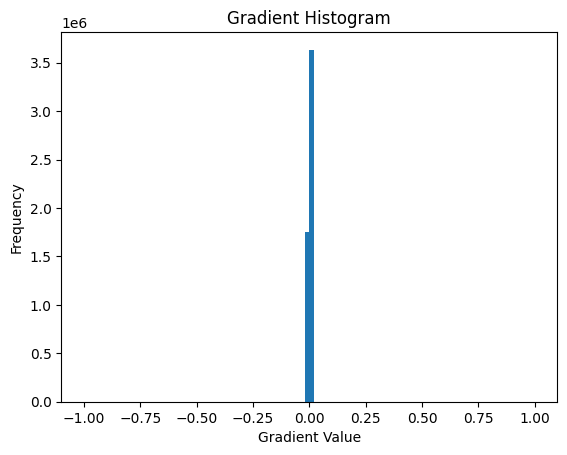

val Loss: 131.7744 Acc: 78.6364
Training complete in 4m 26s
Best val Acc: 78.636364


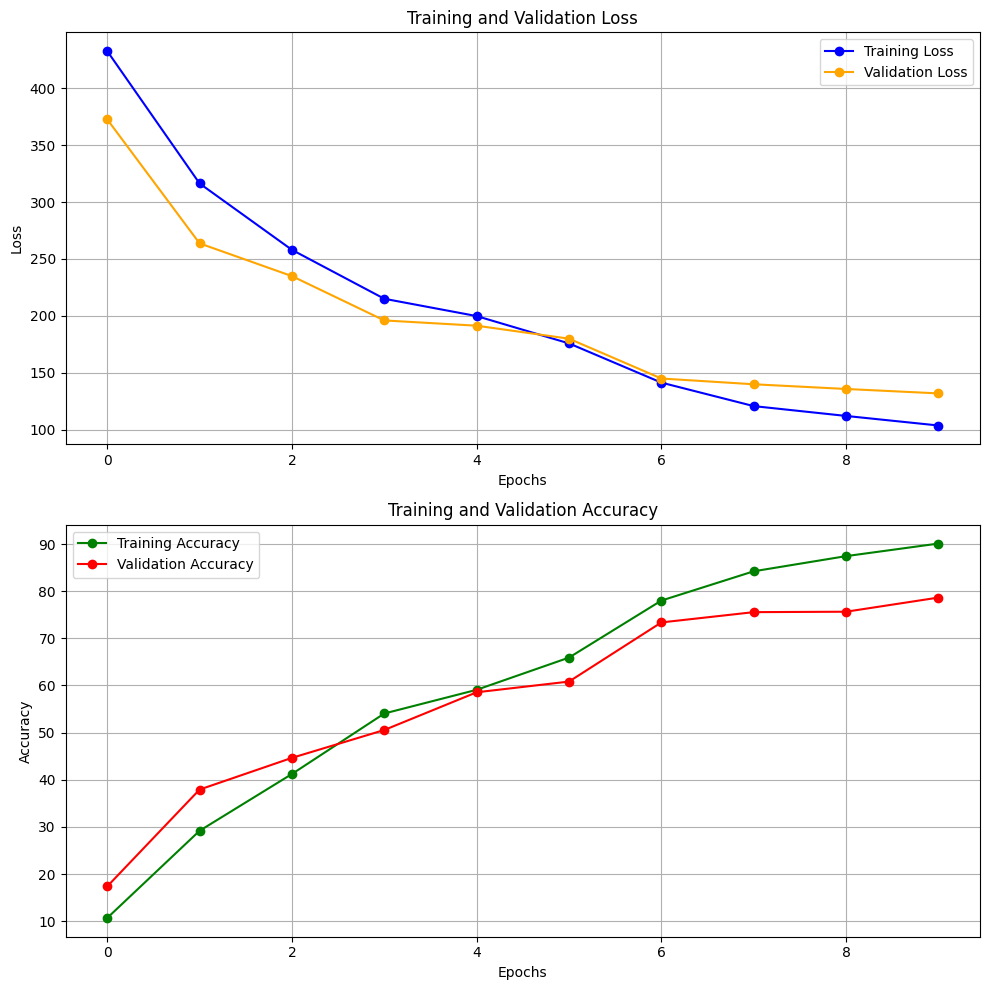

In [ ]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=epochs, batch_size=bs)

ValueError: Unknown format code 'd' for object of type 'float'

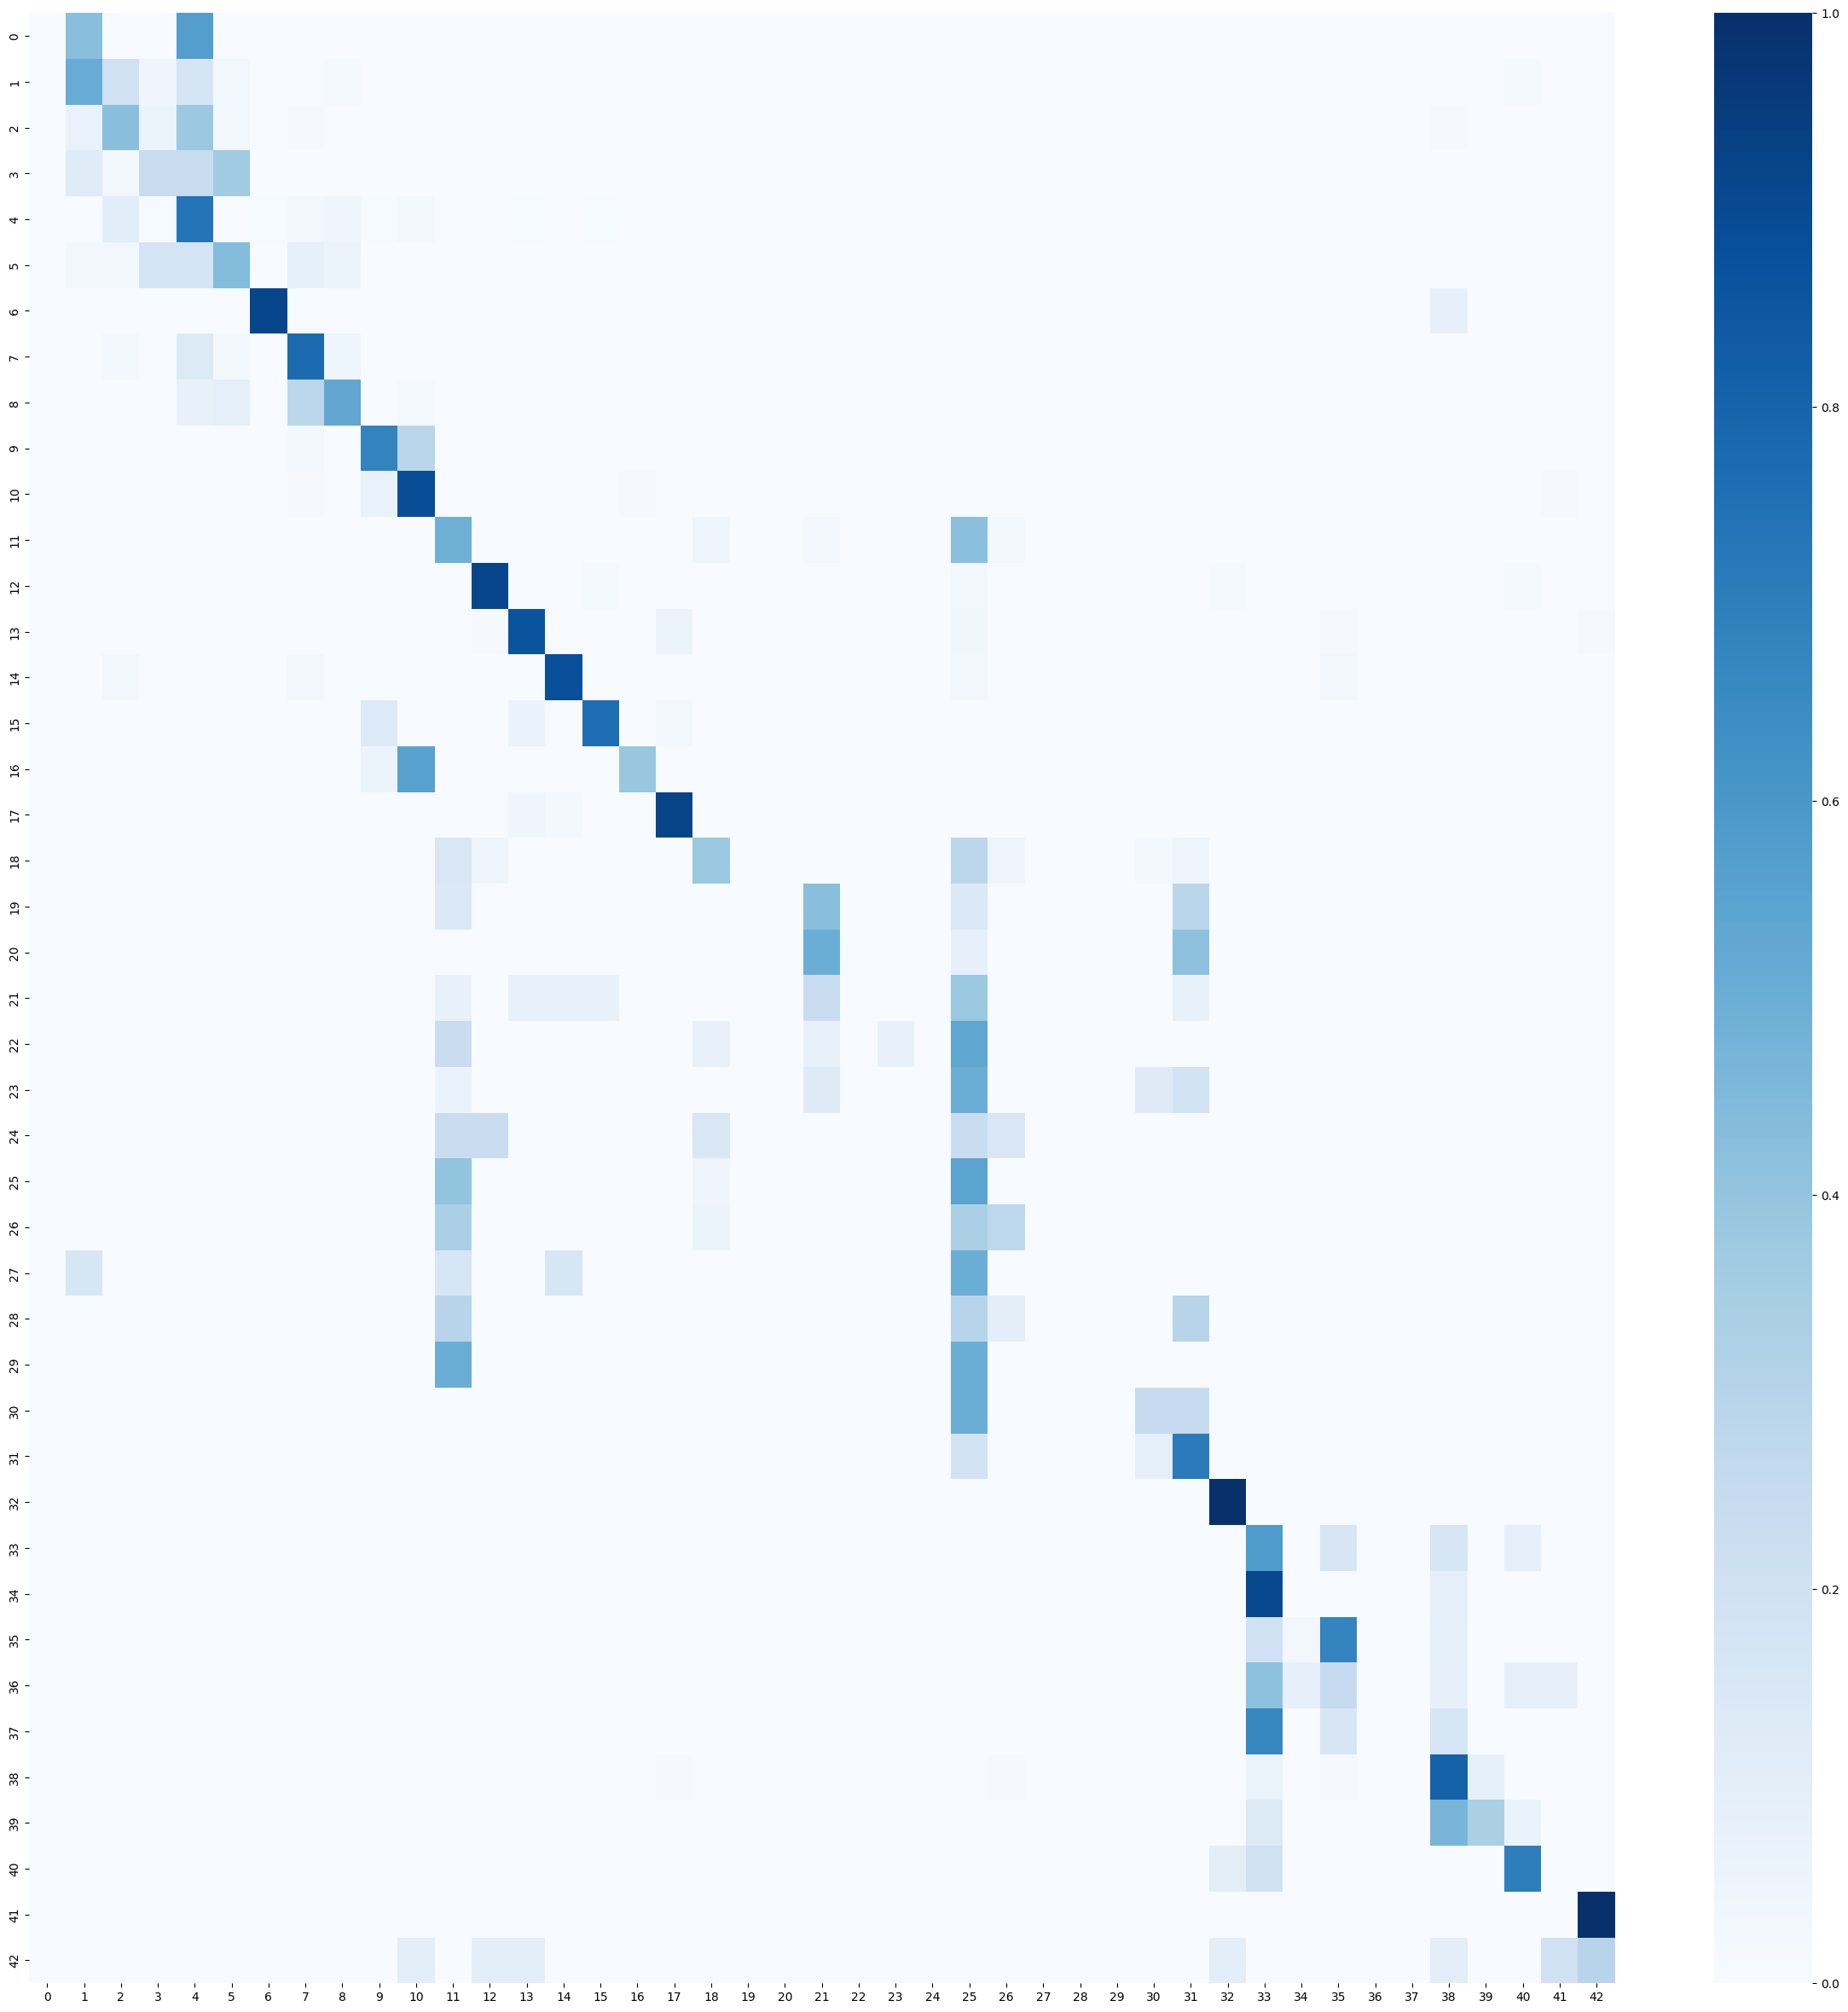

In [ ]:
conf_matrix = evaluate_model(model, test_vis_set, bs)

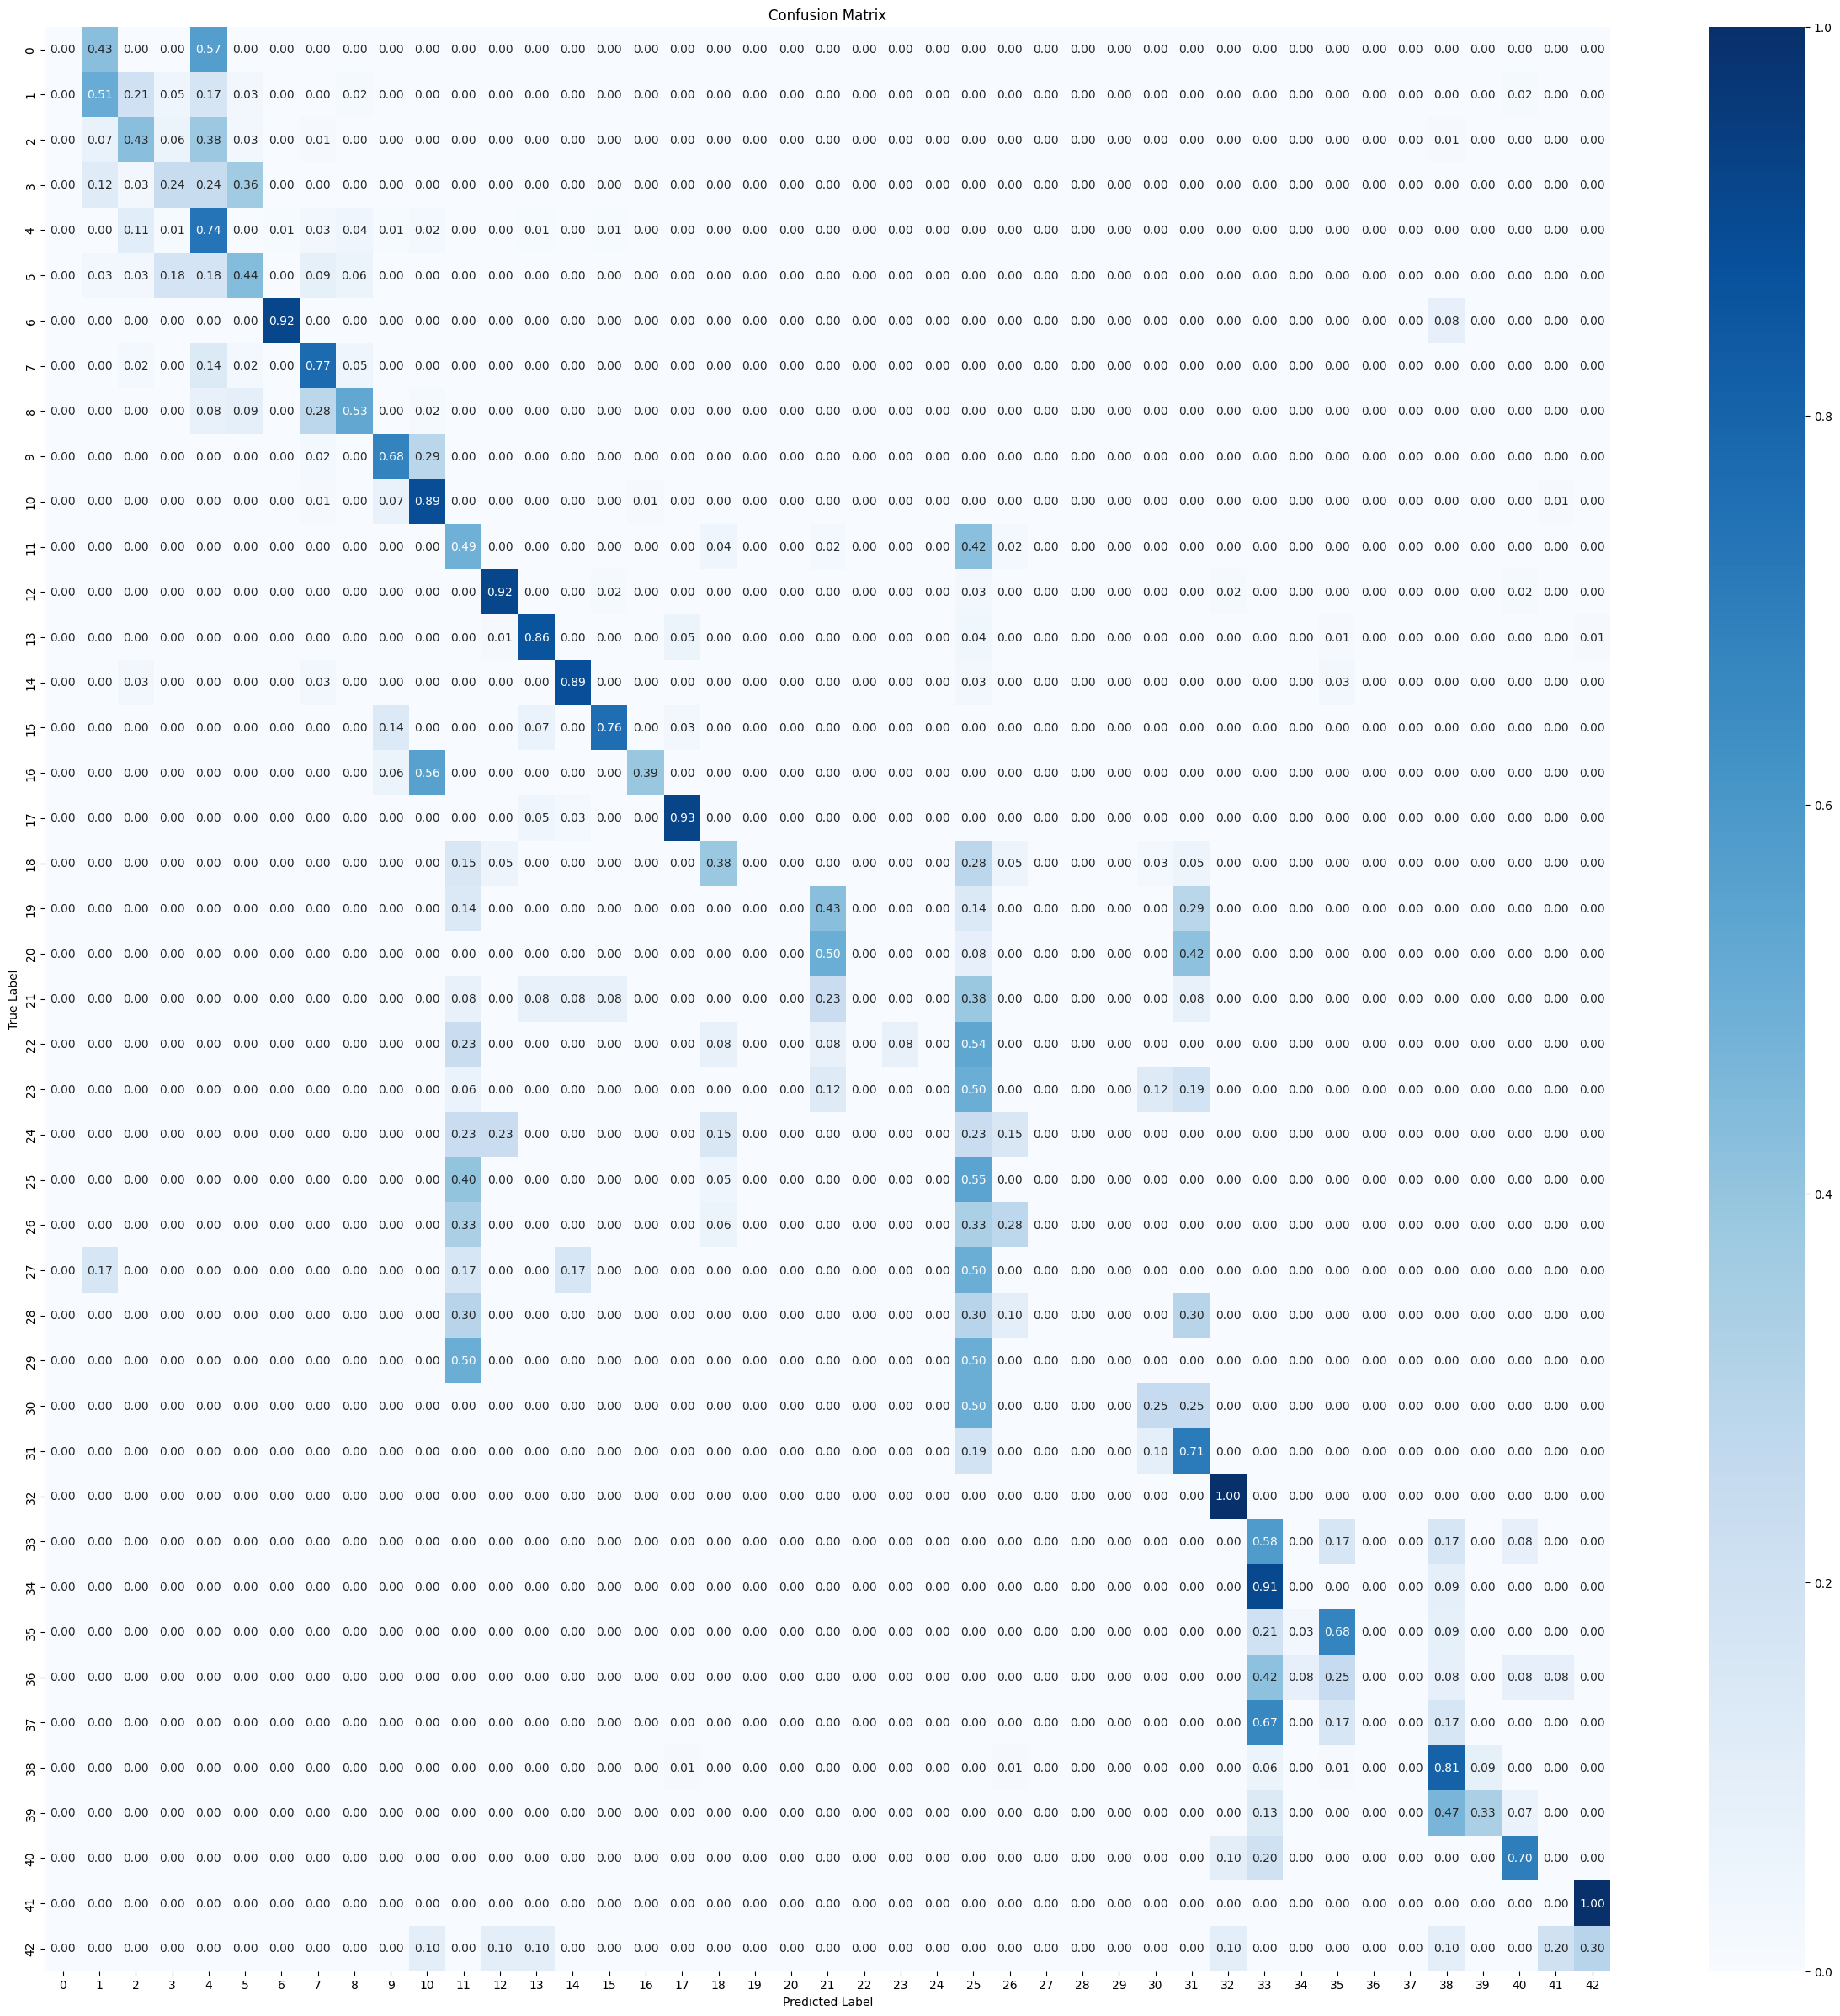

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### **Visualization of the classification layers**




#### Grad-Cam

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=88ea1a7112b0ec5e52a14ba2c007a0b91c05ec679b2a9b36d973ced3559327b7
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model.features[18][0]]

In [ ]:
cam = GradCAM(model=model, target_layers=target_layers)

In [ ]:
input, labels = next(iter(test_vis_data_loader))

In [ ]:
print(input.shape)

torch.Size([64, 3, 224, 224])


In [ ]:
grayscale_cam = cam(input_tensor=input)

In [ ]:
print(len(grayscale_cam))

64


In [ ]:
#We select the one corresponding to the first image
grayscale_cam_first = grayscale_cam[0, :]

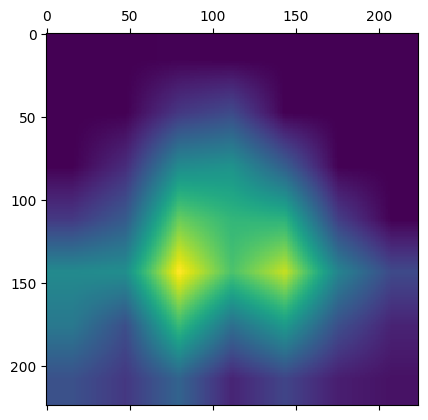

In [ ]:
plt.matshow(grayscale_cam_first)

In [ ]:
import numpy
#Extract the first image
image = torchvision.transforms.ToPILImage()(input.data[0])

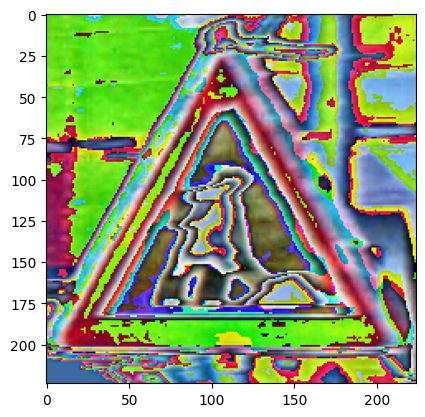

In [ ]:
#But it looks weird this way
plt.imshow(image)

In [ ]:
#Now me need to unnormalize the images we have been using since our mean = [0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [ ]:
denormalized_image = torchvision.transforms.ToPILImage()(invTrans(input.data[0]))

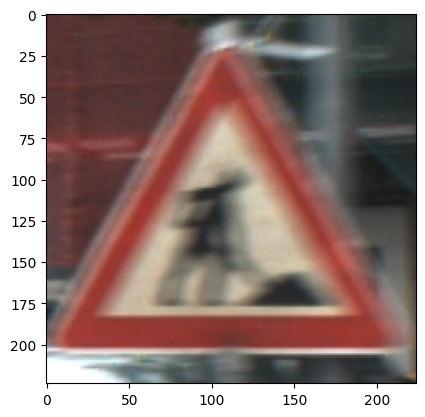

In [ ]:
#We can now visualize the image
plt.imshow(denormalized_image)

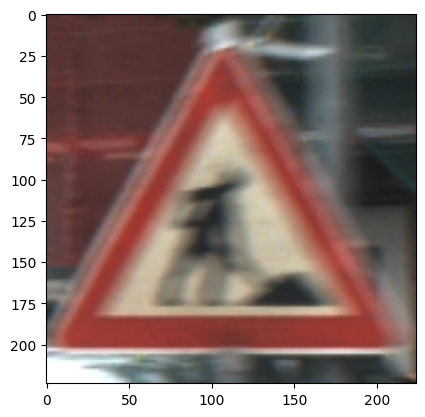

In [ ]:
#We transform the picture into a numpy array
pic = (numpy.array(denormalized_image) / 255.0)

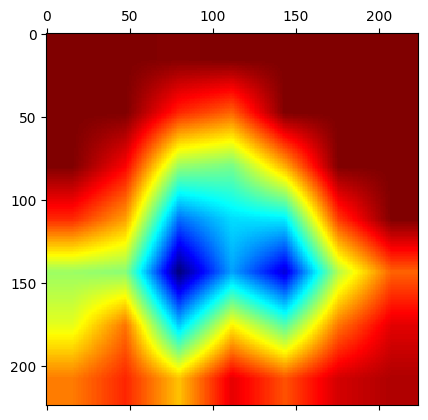

In [ ]:
heatmap = cv2.resize(grayscale_cam_first, (pic.shape[1], pic.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.matshow(heatmap)

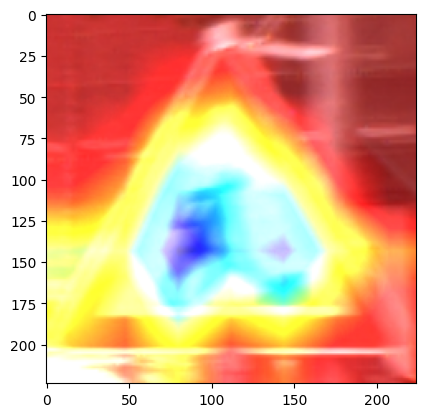

In [ ]:
img_with_heatmap = (heatmap / 255) * 0.9 + pic
plt.imshow(img_with_heatmap)

In [ ]:
print(input.data[63].shape)

torch.Size([3, 224, 224])


In [ ]:
#Let's see what happens with labels that are wrongly predicted, for example class 0.
iterable = iter(test_vis_data_loader)
class_0 = []

while class_0 == [] :

  input, labels = next(iterable)

  class_0 = [(input.data[i], labels.data[i]) for i in range(input.shape[0]) if labels.data[i].item() == 0]



In [ ]:
input_0, label_0 = class_0[0]

tensor([[[ 0.5878,  0.6049,  0.6049,  ...,  0.2282,  0.2111,  0.2111],
         [ 0.5878,  0.6049,  0.6049,  ...,  0.1768,  0.1597,  0.1597],
         [ 0.5707,  0.5878,  0.5878,  ..., -0.0801, -0.1143, -0.1143],
         ...,
         [-1.3815, -1.3644, -1.3815,  ..., -1.2617, -1.2959, -1.3473],
         [-1.3815, -1.3815, -1.3987,  ..., -1.2788, -1.3130, -1.3644],
         [-1.3815, -1.3815, -1.3987,  ..., -1.2959, -1.3302, -1.3815]],

        [[-1.3179, -1.3179, -1.3179,  ...,  0.1176,  0.1352,  0.1352],
         [-1.3179, -1.3179, -1.3179,  ...,  0.1702,  0.1877,  0.1702],
         [-1.3004, -1.3004, -1.3004,  ..., -0.0924, -0.0749, -0.0924],
         ...,
         [-1.2304, -1.2129, -1.2304,  ..., -0.9853, -1.0378, -1.0728],
         [-1.2304, -1.2304, -1.2479,  ..., -1.0028, -1.0553, -1.0903],
         [-1.2129, -1.2304, -1.2304,  ..., -1.0203, -1.0553, -1.0903]],

        [[-1.1247, -1.1073, -1.0898,  ...,  0.3393,  0.3393,  0.3393],
         [-1.1247, -1.1073, -1.0898,  ...,  0

In [ ]:
denormalized_image_0 = torchvision.transforms.ToPILImage()(invTrans(input_0.data))
pic_0 = (numpy.array(denormalized_image_0) / 255.0)

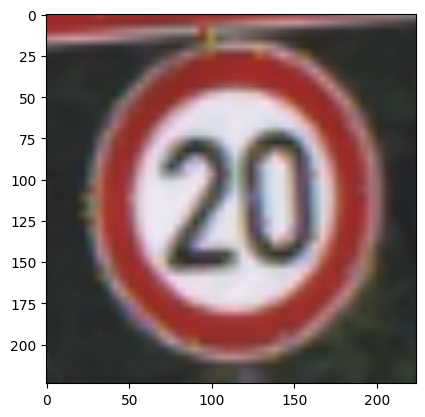

In [ ]:
plt.imshow(denormalized_image_0)

In [ ]:
grayscale_cam_0 = cam(input_tensor=input_0.unsqueeze(0))
grayscale_cam_0 = grayscale_cam_0[0]

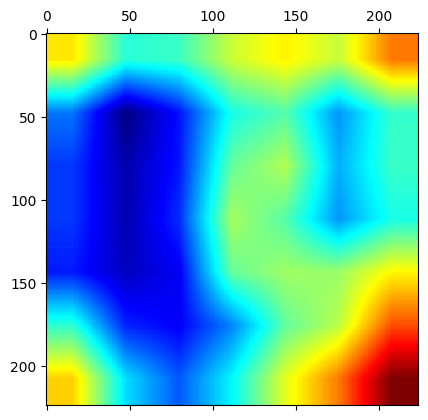

In [ ]:
heatmap_0 = cv2.resize(grayscale_cam_0, (pic_0.shape[1], pic_0.shape[0]))
heatmap_0 = np.uint8(255 * heatmap_0)
heatmap_0 = cv2.applyColorMap(heatmap_0, cv2.COLORMAP_JET)
plt.matshow(heatmap_0)

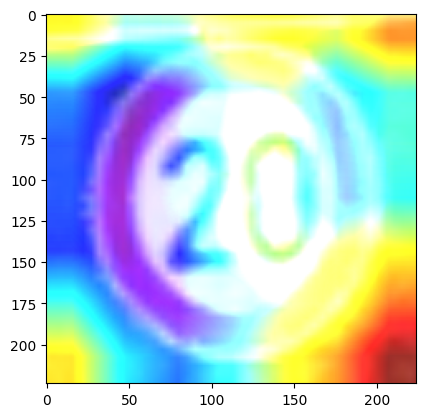

In [ ]:
img_with_heatmap_0 = (heatmap_0 / 255) * 0.9 + pic_0
plt.imshow(img_with_heatmap_0)


### **Data augmentation functions**

In [ ]:
!pip install torchmetrics

In [ ]:
few_img_classes = [0, 6, 16, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 32, 34, 36, 37, 39, 40, 41, 42]

filtering data form original dataset

In [ ]:
def get_filtererd_dataset(dataset, filter_classes):
  indices = [i for i, (_, label) in enumerate(dataset) if label in filter_classes] # gets indexes of images from classes specified into a list

  return Subset(dataset, indices) # making subset with image indexes from train set

filtered_dataset = get_filtererd_dataset(train_set, few_img_classes)

Transformations on images

In [ ]:
transform_1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(-15, 15)),              # Tilt signs
    torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)  # Color variations
])

transform_2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Shift signs
    torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5)  # Perspective warp
])

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        new_image = self.transform(image)
        return new_image, label

augmented_dataset_1 = AugmentedDataset(filtered_dataset, transform_1)
augmented_dataset_2 = AugmentedDataset(filtered_dataset, transform_2)

Creating extended dataset

In [ ]:
train_set = ConcatDataset([train_set, augmented_dataset_1, augmented_dataset_2])

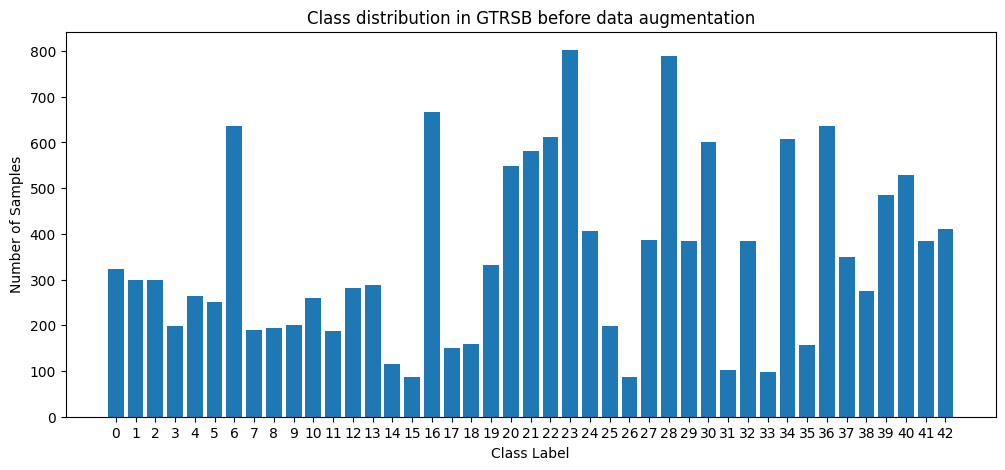

In [ ]:
def visualize_dataset_distribution(data_loader, title_extending):
  # Initialize a counter to keep track of class labels
  class_counts = Counter()

  # Iterate through the subset
  for images, labels in data_loader:
      class_counts.update(labels.numpy())  # Update the counter with the labels of this batch

  # Convert the counter to a sorted list
  sorted_class_counts = sorted(class_counts.items())

  # Unzip the sorted counts
  classes, counts = zip(*sorted_class_counts)

  # Plot the class distribution
  plt.figure(figsize=(12, 5))
  plt.bar(classes, counts)
  plt.xlabel('Class Label')
  plt.ylabel('Number of Samples')
  plt.title(f'Class distribution in GTRSB {title_extending}')
  plt.xticks(classes)  # Show class labels on x-axis
  plt.show()

train_loader_vis = DataLoader(train_set, batch_size=64, shuffle=False)
visualize_dataset_distribution(train_loader_vis, "before data augmentation")

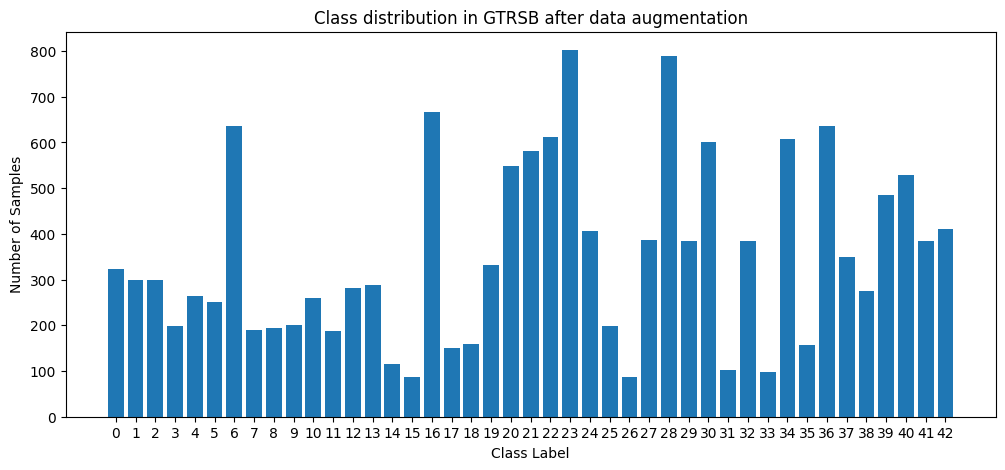

In [ ]:
train_loader_vis = DataLoader(train_set, batch_size=64, shuffle=False)
visualize_dataset_distribution(train_loader_vis, "after data augmentation")

Visualize it again, now the extended dataset

Code to get 300 images of every class

In [ ]:
def get_n_images(dataset, num_of_images_per_class):
  class_indices = defaultdict(list)

  for idx, (_, label) in enumerate(dataset):
      class_indices[label].append(idx)

  selected_indices = []

  for label, indices in class_indices.items():
      selected_indices.extend(random.sample(indices, num_of_images_per_class)) # get random set of indices, better than getting first n images

  return Subset(dataset, selected_indices)

first_n_dataset = get_n_images(train_set, 300)
first_n_loader = DataLoader(first_n_dataset, batch_size=64, shuffle=False)
visualize_dataset_distribution(first_n_loader, "first 300 images per class")